<a id='top'></a>

# Powder Mountain Aquifer Test Data

##Table of Contents
-[Data Sources](#Data-Sources)<br>
-[Climate Data](#Climate-Data)<br>
-[Upper Lefty's Spring](#Upper-Lefty's-Spring)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting Upper Lefty's Spring Data](#Importing-and-Converting-Upper-Lefty's-Spring-Data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Comparing the Data](#Comparing-the-Data)<br>
-[Lower Lefty's Spring](#Lower-Lefty's-Spring)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting Lower Lefty's Spring Data](#Importing-and-Converting-Lower-Lefty's-Spring-Data)<br>
-[Hidden Lake Spring](#Hidden-Lake-Spring)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting Hidden Lake Spring Data](#Importing-and-Converting-Hidden-Lake-Spring-Data)<br>
-[North Boundary Weir](#North-Boundary-Weir)<br>
&nbsp;&nbsp;&nbsp;&nbsp;-[Importing and Converting North Boundary Weir Data](#Importing-and-Converting-North-Boundary-Weir-Data)<br>
-[Hidden Lake Well](#Hidden-Lake-Well)<br>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.stats as sp
import statsmodels.api as sm
from pandas.stats.api import ols
from datetime import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
print 'Pandas version ' + pd.__version__

Pandas version 0.16.2


In [3]:
def smoother(df, p, win, sd):
    '''
    remove outliers from a pandas dataframe column and fill with interpolated values
    warning: this will fill all NaN values in the dataframe with the interpolate function
    df= dataframe of interest
    p= column in dataframe with outliers
    win= size of window
    std= number of standard deviations allowed
    '''
    df1 = df
    df1['dp'+ p] = df1[p].diff()
    df1['ma'+ p] = pd.rolling_mean(df1['dp'+ p], window=win, center=True)
    df1['mst'+p] = pd.rolling_std(df1['dp'+ p], window=win, center=True)
    for i in df.index:
        try:
            if abs(df1['dp'+ p][i] - df1['ma'+ p][i]) >= abs(df1['mst'+p][i]*sd):
                df[p][i]=np.nan
            else:
                df[p][i]=df[p][i]
        except (ValueError):
            try:
                if abs(df1['dp'+ p][i] - df1['ma'+ p][i]) >= abs(df1['dp'+p].std()*sd):
                    df[p][i]=np.nan
                else:
                    df[p][i]=df[p][i]
            except (ValueError):
                df[p][i]=df[p][i]
    del df1
    df = df.interpolate(method='time')
    df = df[1:-1]
    return df

In [4]:
def rollmeandiff(df1,p1,df2,p2,win):
    '''
    returns the rolling mean difference of two columns from two different dataframes
    df1 = dataframe 1
    p1 = column in df1
    df2 = dataframe 2
    p2 =column in df2
    win = window in days
    '''
    win = win*60*24
    df1 = df1.resample('1Min', how='mean')
    df1 = df1.interpolate(method='time')
    df2 = df2.resample('1Min', how='mean')
    df2 = df2.interpolate(method='time')
    df1['rm'+p1] = pd.rolling_mean(df1[p1], window=win, center=True)
    df2['rm'+p2] = pd.rolling_mean(df2[p2], window=win, center=True)
    df3 = pd.merge(df1,df2,left_index=True, right_index=True, how='outer')
    df3 = df3[np.isfinite(df3['rm'+p1])]
    df4 = df3[np.isfinite(df3['rm'+p2])]
    df5 = df4['rm'+p1] - df4['rm'+p2]
    diff = round(df5.mean(),3)
    del (df3,df4,df5)
    return diff

In [5]:
def nodups(df,dfbig):
    some_list = list(df.columns.values)
    for i in range(len(some_list)):
        if some_list[i] in list(dfbig.columns.values):
            df = df.drop(some_list[i], axis=1)
        elif "_Q_" in some_list[i] or "t_C" in some_list[i] or "date" in some_list[i] or "dt" in some_list[i] or "_BP_" in some_list[i] or "_elev_" in some_list[i] or "SF_AD" in some_list[i] or "PPT_in" in some_list[i]:
            pass
        else:
            try:
                df = df.drop(some_list[i], axis=1)
            except (NameError,ValueError):
                pass
    return df


In [6]:
def jumpfix(df,meas, threashold=0.005):
    '''
    removes jumps or jolts in time series data (where offset is lasting)
    df = dataframe to manipulate
    meas = name of field with jolts
    threashold = size of jolt to search for'''
    df['delta'+meas] = df[meas].diff()
    jump = df[abs(df['delta'+meas])>threashold]
    jump['cumul'] = jump['delta'+meas].cumsum()
    df['newVal'] = df[meas]
    for i in range(len(jump)):
        jt = jump.index[i]
        ja = jump['cumul'][i]
        #df.loc[:jt,'newVal'] =df[meas]
        df.loc[jt:,'newVal'] = df[meas].apply(lambda x: x-ja,1)
    df[meas]=df['newVal']
    return df

## Data Sources

[To top of page](#top)

In [7]:
rootlocal = 'E:/PROJECTS/POWMOW/'
#rootlocal = '/media/p/Transcend/PROJECTS/POWMOW/'

This section allows for rapid adjustment of the locations of the source files as they are updated/changed.

In [8]:
USU_Data = rootlocal + 'E5382-MonitoringData/Information Received from UGS/USU_data.xlsx'
SNOTEL_Data = rootlocal + 'E5382-MonitoringData/Information Received from UGS/582_ALL_YEAR=2014.csv'

Paths to Leftys Spring weir data. <br>
[Loughlin data import](#leftys); [Loughlin BP import](#leftysbp); [Files data import](#leftysfiles); [Manual Readings](#leftysman)

In [9]:
Upper_Leftys_Loughlin = rootlocal + 'E5382-MonitoringData/lefty spring wls_150103085317_N3263.CSV'
Upper_Leftys_Barometer_Loughlin = rootlocal + 'E5382-MonitoringData/lefty spring baromer_150103084642_P5348.csv'
Upper_Leftys_John_Files = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LEFTYSSPRINGVENTD 2015-01-01 11.16.01.wsl.csv'
Upper_Leftys_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to Lower Leftys weir data.<br>
[Loughlin data import](#lower); [Loughlin BP import](#leftysbp1); [Files data import](#fileslower); [Manual Readings](#lowerman)

In [10]:
Lower_Leftys_Loughlin = rootlocal + 'E5382-MonitoringData/below lefty spring_150103090632_S4811.CSV'
Lower_Leftys_John_Files = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LOWER LEFTYS SPRING NOV26 2015-01-01 10.47.45.wsl.csv'
Lower_Leftys_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'
Lower_Leftys_John_Files2 = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LOWERLEFTYS2015_Append_2015-04-03_15-05-57-229.csv'
Lower_Leftys_John_Files3 = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/LOWERLEFTYS2015_Append_2015-10-04_.xlsx'

Paths to Hidden Lake weir data.<br>
[Loughlin data import](#hidden); [Loughlin BP import](#hiddenbp); [Files data import](#hiddenfiles); [Manual Readings](#hiddenman)

In [11]:
Hidden_Lake_Loughlin = rootlocal + 'E5382-MonitoringData/hidden lake weir_150103083626_S4264.CSV'
Hidden_Lake_Barometer_Loughlin = rootlocal + 'E5382-MonitoringData/northside barometer_150103090335_G5805.CSV'
Hidden_Lake_John_Files = rootlocal + 'E5382-MonitoringData/Information Received from Protestants/Wellsville 2015-01-01 13.59.01.wsl.csv'
Hidden_Lake_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to North Boundary weir data.<br>
[Loughlin data import](#nb); [Loughlin BP import](#nbbp); [UGS data import](#nbugs); [Manual Readings](#northman)

In [12]:
North_Boundary_Loughlin = rootlocal + 'E5382-MonitoringData/north boundary weir_150103091930_S4248.CSV'
North_Boundary_UGS = rootlocal + 'E5382-MonitoringData/Information Received from UGS/WELLSVILE NORTH BOUNDARY_12_19_2014.csv'
North_Boundary_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to Hidden Lake Well.<br>
[Loughlin data import](#hlw); [Loughlin BP import](#leftysbp2); [Manual Readings](#hlwman)

In [13]:
Hidden_Lake_Well = rootlocal + 'E5382-MonitoringData/HLW-2015-01-02.xls'
Hidden_Lake_Well_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'

Paths to Exploration Well 2.<br>
[Loughlin data import](#exw); [Loughlin BP import](#exbp); [Manual Readings](#exman)

In [14]:
Exploration_Well_2 = rootlocal + 'E5382-MonitoringData/Long-Term Pumping Test_Append_2015-01-03_12-26-45-976.csv'
Exploration_Well_2_Manual = rootlocal + 'E5382-MonitoringData/Information Received from UGS/Manual_Readings_Compilation.xlsx'
oldwls2013 = rootlocal + "E5382-MonitoringData/Information Received from Protestants/ExplWell2Long term.xlsx"

Where to output data

In [15]:
OUT = rootlocal + 'all.csv'

## Climate Data

[To top of page](#top)

### SNOTEL

Import hourly SNOTEL data downloaded from the <a href='http://www.wcc.nrcs.usda.gov/nwcc/site?sitenum=582'> Little Bear SNOTEL station</a>. The path to the input file can be found in the [data sources](#Data-Sources) section. 

In [16]:
SNOTEL = pd.read_csv(SNOTEL_Data, parse_dates=[[1,2]], index_col=0, skiprows=2, engine='python')
SNOTEL = SNOTEL.resample('1Min', how='mean')
SNOTEL = SNOTEL.interpolate(method='time')
SNOTEL = SNOTEL.resample('15Min', how='mean')

### USU

Import hourly data downloaded from the Utah State University (USU) <a href=http://icewater.usu.edu/Data-Query>HydroServer</a>. These data include hourly barometric pressure, precipitation, and gage height measurements. The gage height measurements were recorded on the Little Bear River above and below the confluence of greater Davenport Creek. The path to the input file can be found in the [data sources](#Data-Sources) section.

In [17]:
USU_Avon_BP = pd.read_excel(USU_Data, 'Avon Barometric Pressure', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_Avon_BP_mmHg'])

In [18]:
USU_SF_BP = pd.read_excel(USU_Data, 'South Fork Barometric Pressure', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_BP_mmHg'])

In [19]:
USU_SF_PPT = pd.read_excel(USU_Data, 'South Fork Precipitation', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_PPT_in'])

In [20]:
USU_SF_AD = pd.read_excel(USU_Data, 'South Fork h Above Davenport', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_AD_h_ft'])

In [21]:
USU_SF_BD = pd.read_excel(USU_Data, 'South Fork h Below Davenport', index_col=0, na_values=['-9999',''],
                          parse_cols=[0,1], skiprows=0, names=['dt','USU_SF_BD_h_ft'])

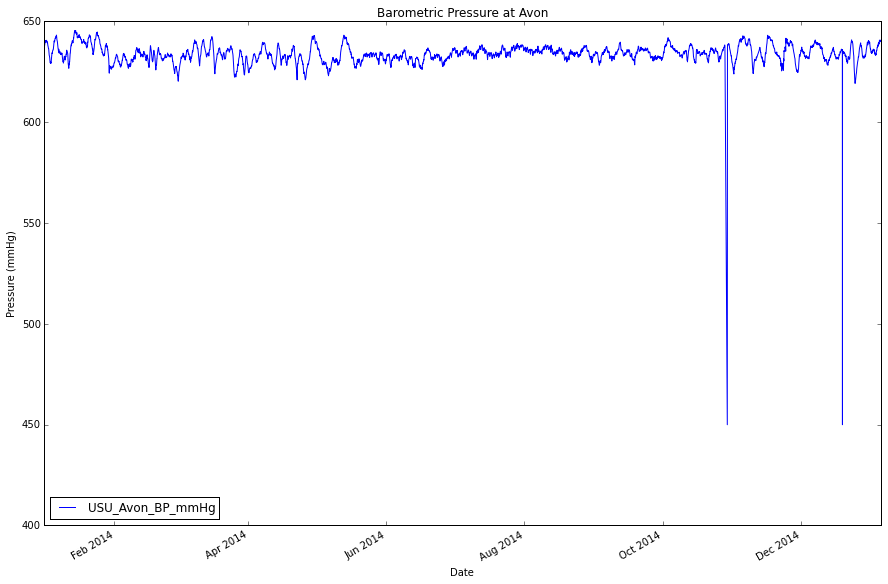

In [22]:
USU_Avon_BP.plot()
plt.title('Barometric Pressure at Avon')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Date')

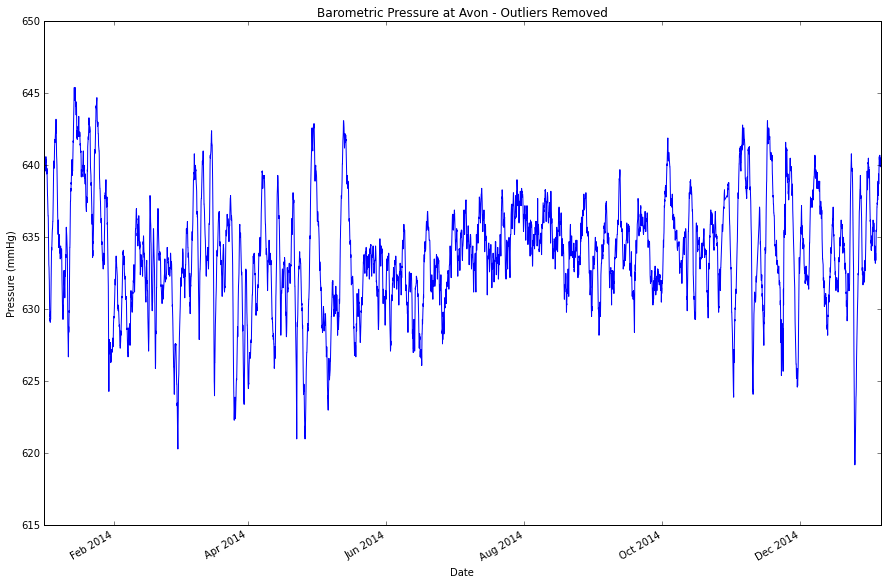

In [23]:
USU_Avon_BP = smoother(USU_Avon_BP,'USU_Avon_BP_mmHg',100,4)
USU_Avon_BP['USU_Avon_BP_mmHg'].plot()
plt.title('Barometric Pressure at Avon - Outliers Removed')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Date')

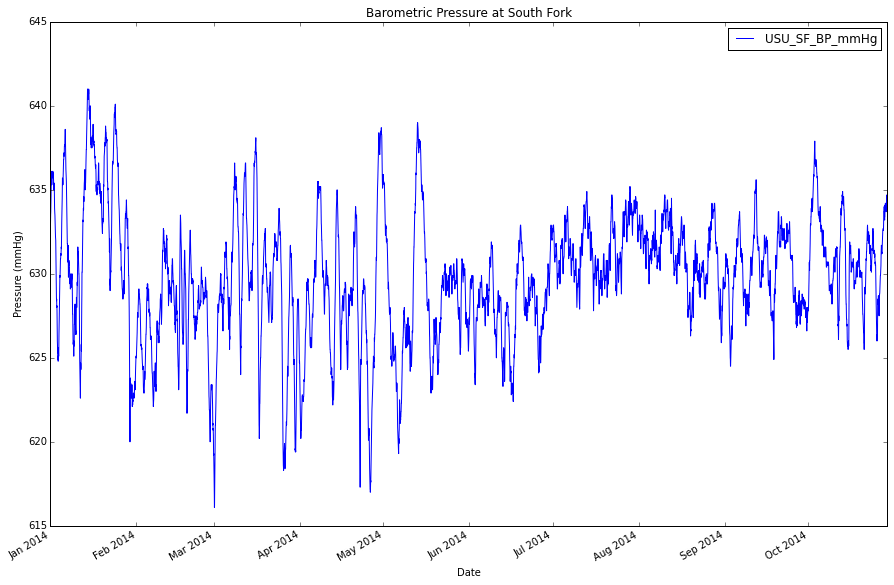

In [24]:
USU_SF_BP.plot()
plt.title('Barometric Pressure at South Fork')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Date')

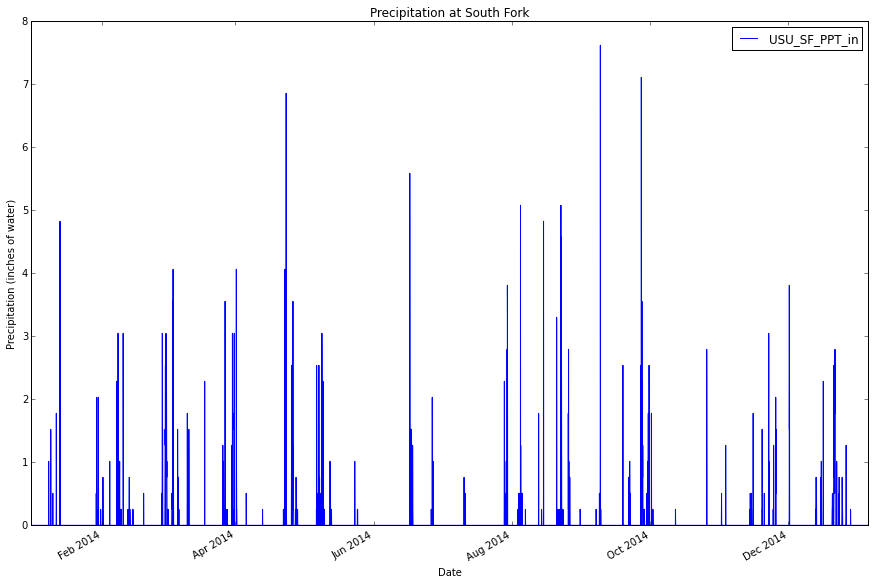

In [25]:
USU_SF_PPT.plot()
plt.title('Precipitation at South Fork')
plt.ylabel('Precipitation (inches of water)')
plt.xlabel('Date')

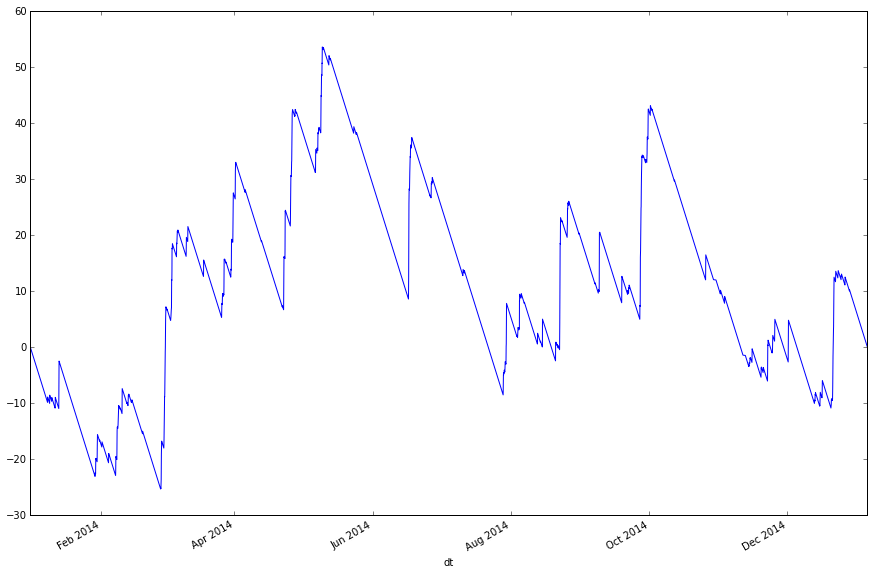

In [26]:
USU_SF_PPT['USU_PPT_CDM']=(USU_SF_PPT['USU_SF_PPT_in']-USU_SF_PPT['USU_SF_PPT_in'].mean()).cumsum()
USU_SF_PPT['USU_PPT_CDM'].plot()

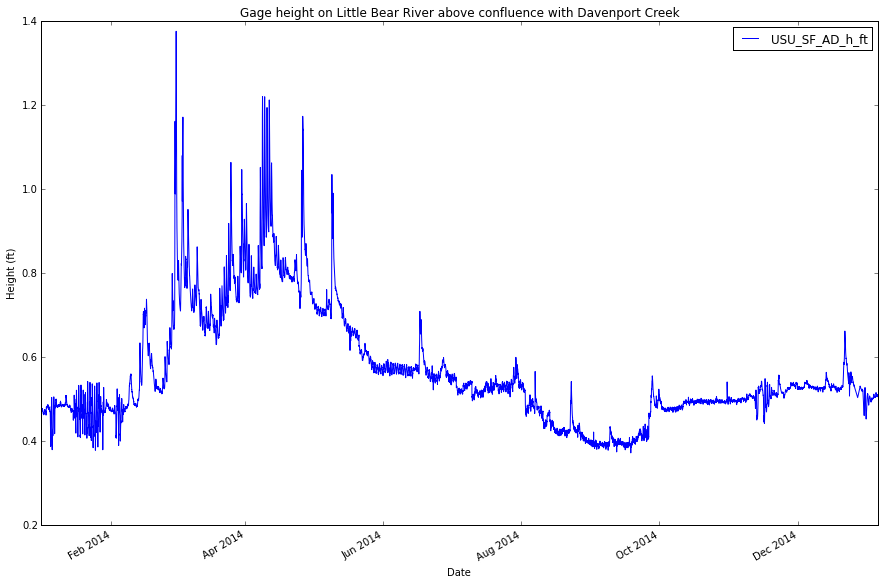

In [27]:
USU_SF_AD.plot()
plt.title('Gage height on Little Bear River above confluence with Davenport Creek')
plt.ylabel('Height (ft)')
plt.xlabel('Date')

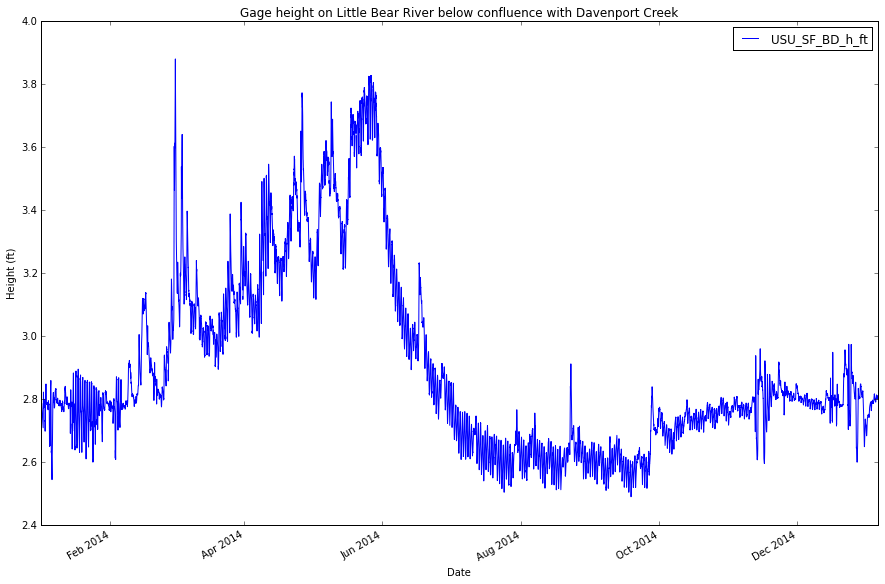

In [28]:
USU_SF_BD.plot()
plt.title('Gage height on Little Bear River below confluence with Davenport Creek')
plt.ylabel('Height (ft)')
plt.xlabel('Date')

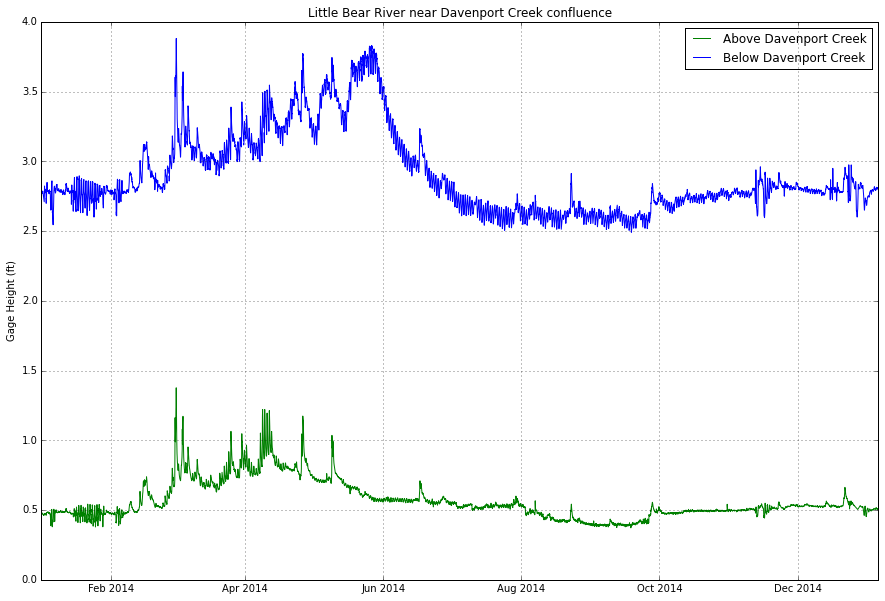

In [29]:
plt.figure()
x1 = USU_SF_AD.index.to_datetime()
y1 = USU_SF_AD['USU_SF_AD_h_ft']

x2 = USU_SF_BD.index.to_datetime()
y2 = USU_SF_BD['USU_SF_BD_h_ft']

plt.figure()
plt.title('Little Bear River near Davenport Creek confluence')
plt.plot(x1,y1,c='g', label='Above Davenport Creek')
plt.plot(x2,y2,c='b', label='Below Davenport Creek')
plt.ylabel('Gage Height (ft)') 
plt.legend(loc=0)
plt.grid()
plt.show()

In [30]:
# Combine imported worksheets into a single dataframe
USU = pd.merge(USU_Avon_BP, USU_SF_BP, left_index=True, right_index=True, how='outer')
USU = pd.merge(USU, USU_SF_PPT,  left_index=True, right_index=True, how='outer')
USU = pd.merge(USU, USU_SF_AD,  left_index=True, right_index=True, how='outer')
USU = pd.merge(USU, USU_SF_BD,  left_index=True, right_index=True, how='outer')

In [31]:
USU = USU.resample('1Min', how='mean')
USU = USU.interpolate(method='time')
USU = USU.resample('15Min', how='mean')

In [32]:
del(USU_Avon_BP, USU_SF_PPT, USU_SF_AD, USU_SF_BD)

In [33]:
USU = USU.drop(['dpUSU_Avon_BP_mmHg', 'maUSU_Avon_BP_mmHg', 'mstUSU_Avon_BP_mmHg'], axis=1)
list(USU.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft']

In [34]:
Climate = pd.merge(USU,SNOTEL, left_index=True, right_index=True, how='outer')

In [35]:
del (USU,SNOTEL)

## Upper Lefty's Spring

### Importing and Converting Upper Lefty's Spring Data

[To top of page](#top)

This weir was installed by the Powder Mountain Water and Sewer District. The weir has the longest record of monitoring for any of the non-developed sites in the study area. The weir is directly downstream of where the main Lefty's springhead emerges, so contribution from overland flow is negligible. This weir has notable seepage and underflow, and is not as "sharp-crested" as a calibrated steel weir, as it is constructed out of plywood and some type of advertisement board.

Import the transducer data collected by Loughlin Water at Upper Lefty's Spring weir. These data are nonvented and provide values of absolute head, so barometric pressure must be subtracted to determine the water head above the transducer. These data extend from 7/25/2014 12:15 to 12/16/2014 17:45.

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id='leftys'></a>

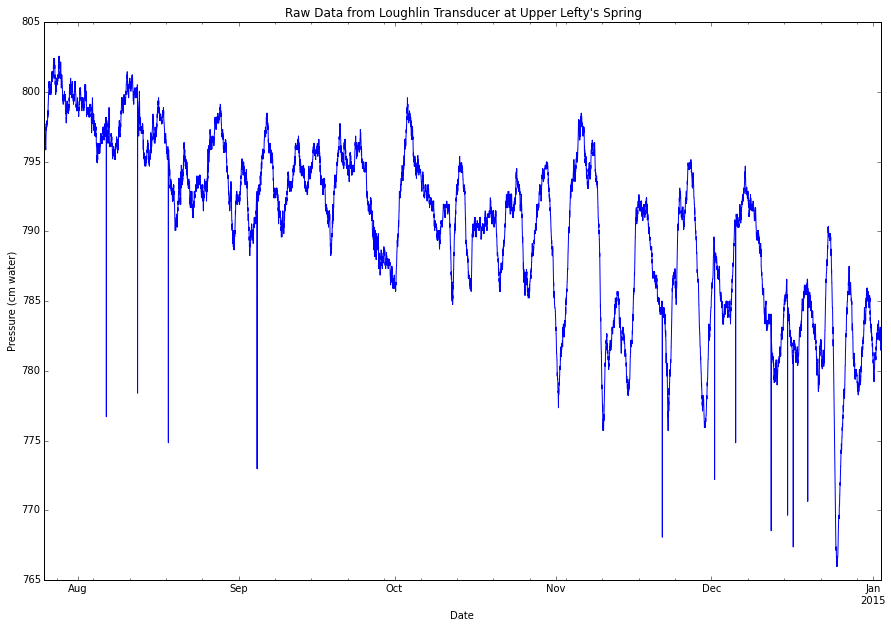

In [36]:
UL_LW = pd.read_csv(Upper_Leftys_Loughlin,
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, 
                    names=['dt','UL_LW_p_cm','UL_LW_t_C'], engine='python')
UL_LW['UL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at Upper Lefty\'s Spring')

Remove obvious outliers created when the transducer was not in the water.

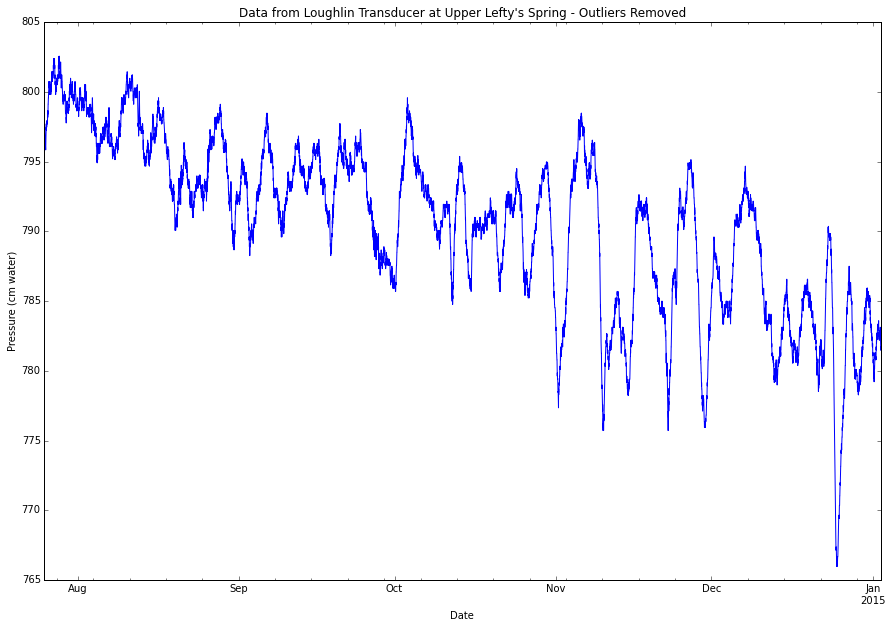

In [37]:
UL_LW = smoother(UL_LW, 'UL_LW_p_cm', 50, 3)
UL_LW['UL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at Upper Lefty\'s Spring - Outliers Removed')

Import the barometric pressure observations collected by Loughlin Water. The path to the input file can be found in the [data sources](#Data-Sources) section. <a id=leftysbp></a>

In [38]:
UL_BP_LW = pd.read_csv(Upper_Leftys_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','UL_BP_LW_p_cm','UL_BP_LW_t_C'], 
                    engine='python')

Plot the barometric pressure and the nonvented transducer data to make sure they match.

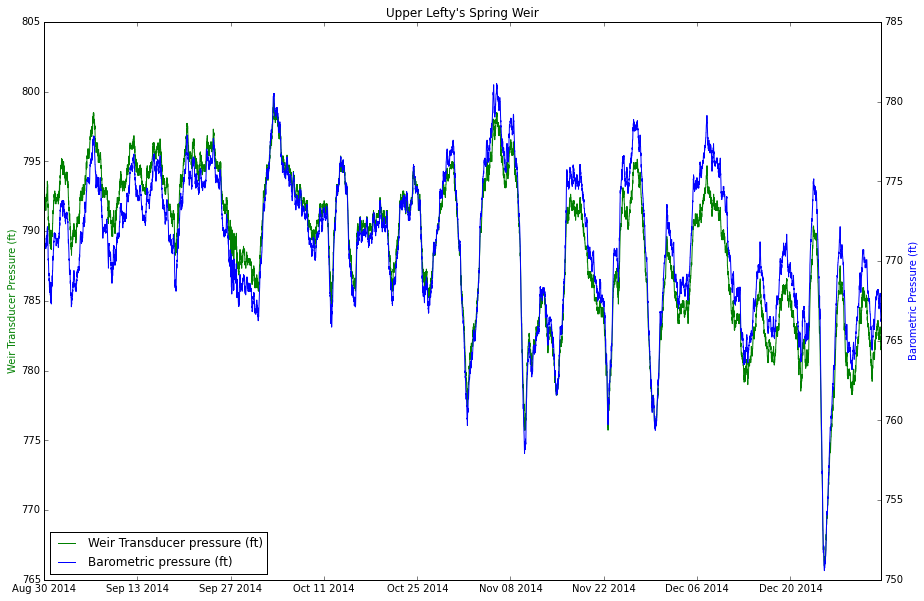

In [39]:
plt.figure()
x1 = UL_LW.index.to_datetime()
y1 = UL_LW['UL_LW_p_cm']

x2 = UL_BP_LW.index.to_datetime()
y2 = UL_BP_LW['UL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('Upper Lefty\'s Spring Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='8/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='g') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

Import the vented transducer data collected by Miranda Menzies and provided by John Files. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=leftysfiles></a>

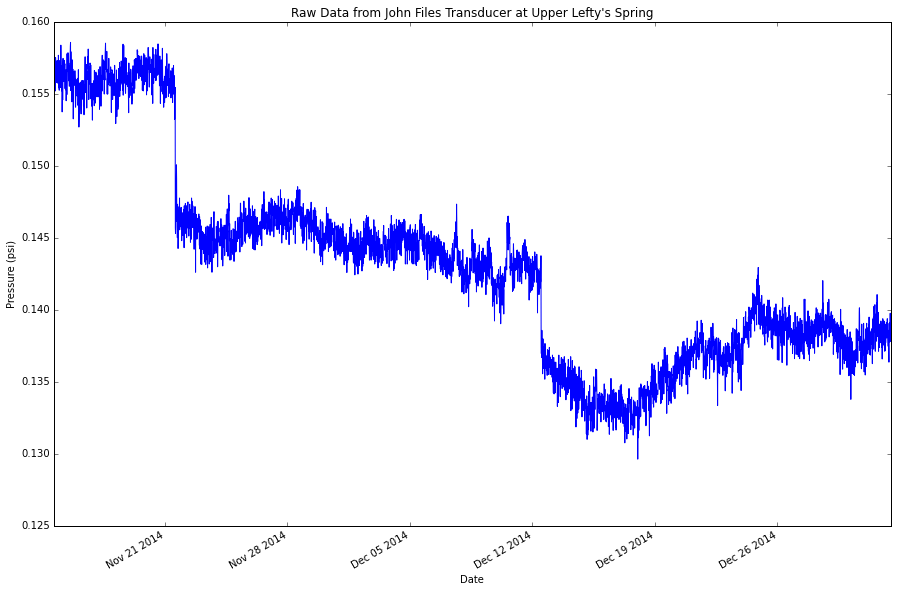

In [40]:
UL_JF = pd.read_csv(Upper_Leftys_John_Files, 
                     index_col=0, skiprows=91, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','UL_JF_p_PSI','UL_JF_t_C'], engine='python')
#first 14 values are out of water
UL_JF = UL_JF[14:]
UL_JF['UL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Upper Lefty\'s Spring')

In [41]:
UL_JF1 = jumpfix(UL_JF,'UL_JF_p_PSI',0.005)

C:\Python27\ArcGIS10.3\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The data have two tears in them, due to adjustments of the transducer locations over time. To accomodate, we search for these tears and use a for statement to remove them.

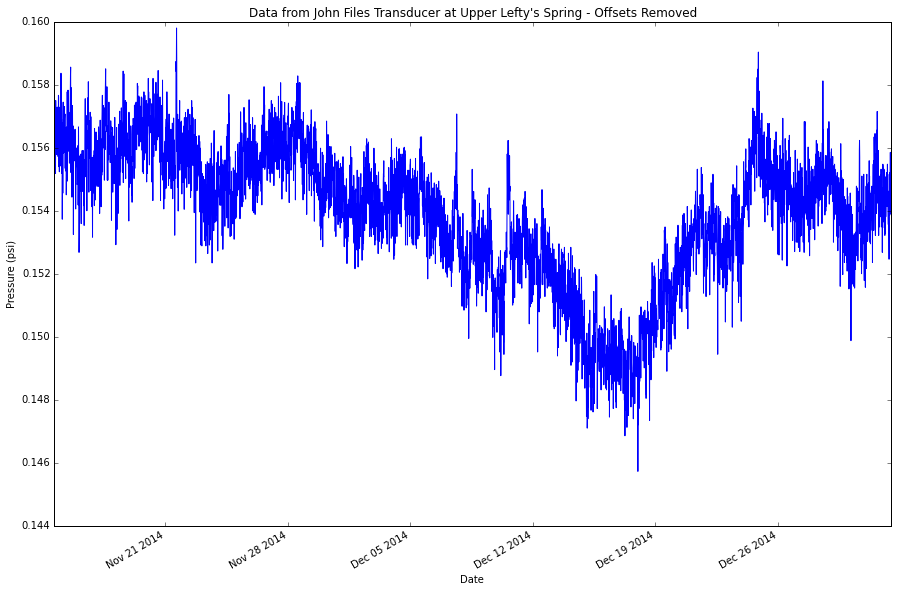

In [42]:
UL_JF1['UL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Data from John Files Transducer at Upper Lefty\'s Spring - Offsets Removed')

These data were collected every 15 minutes, but at odd times that do not align with the Loughlin data, so they have to be resampled and interpolated so that times are consistent and proper comparisons can be made.

In [43]:
UL_JF = UL_JF.resample('1Min', how='mean')
UL_JF = UL_JF.interpolate(method='time')
UL_JF = UL_JF.resample('15Min', how='mean')

Merge the datasets to ease calculation, comparison, and visualization.

In [44]:
Leftys = pd.merge(UL_LW, UL_JF, left_index=True, right_index=True, how='outer')
Leftys = pd.merge(Leftys, UL_BP_LW, left_index=True, right_index=True, how='outer')

Leftys = Leftys[pd.datetime(2014,7,25,12,15):pd.datetime(2014,12,16,17,45)]

Delete old dataframes.

In [45]:
#del (UL_LW,UL_JF)

Import the manual measurements collected at the weir. Import the depth of water at the v. Add the average difference measured between the v-depth and the actual depth (h), which is 0.16 inches. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=leftysman></a>

In [46]:
UL_manual = pd.read_excel(Upper_Leftys_Manual, 'Leftys', index_col=0, skiprows=1,
                          parse_cols=[0,1,2,3], names=['date', 'UL_vdepth_in', 'UL_depth_in', 'UL_bucket_Q_gpm'])
UL_manual['UL_vdepth_ft'] = UL_manual['UL_vdepth_in']/12
UL_manual = UL_manual.sort_index()
UL_manual = UL_manual[UL_manual.index.to_datetime()>pd.datetime(2014,7,25)]

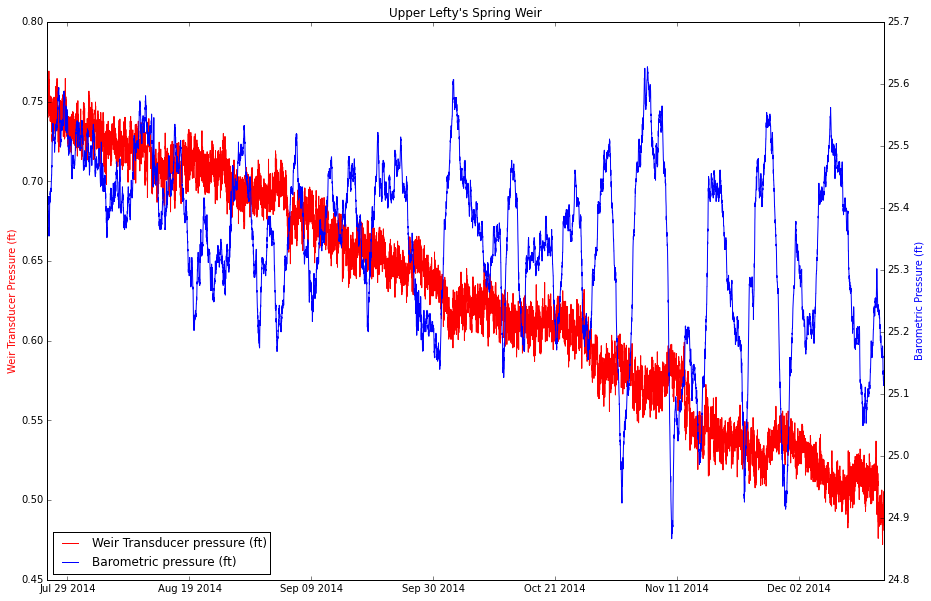

In [47]:
Leftys['UL_LW_p_ft'] =  (Leftys['UL_LW_p_cm'] - Leftys['UL_BP_LW_p_cm'])*0.0328084
Leftys['UL_BP_LW_p_ft'] = Leftys['UL_BP_LW_p_cm']*0.0328084

x = Leftys.index.to_datetime()
y1 = Leftys['UL_LW_p_ft']
y2 = Leftys['UL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
plt.title('Upper Lefty\'s Spring Weir')
ax2 = ax1.twinx()
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

We perform a moving average difference between the manual measurements and the transducer measurements to determine the calibration offset.  This is the difference in height from the transducer measure point and the bottom of the weir orifice.

In [48]:
meanDiff = rollmeandiff(UL_manual,'UL_vdepth_ft',Leftys,'UL_LW_p_ft',5)
print meanDiff
Leftys['UL_LW_h_ft'] = Leftys['UL_LW_p_ft'] + meanDiff

-0.37


We repeat the average difference for the John Files data. First the units of PSI must be converted to feet of water.

In [49]:
Leftys['UL_JF_p_ft'] =  Leftys['UL_JF_p_PSI']*2.307
meanDiff = rollmeandiff(UL_manual,'UL_vdepth_ft',Leftys,'UL_JF_p_ft',5)
print meanDiff
Leftys['UL_JF_h_ft'] = Leftys['UL_JF_p_ft'] + meanDiff

-0.157


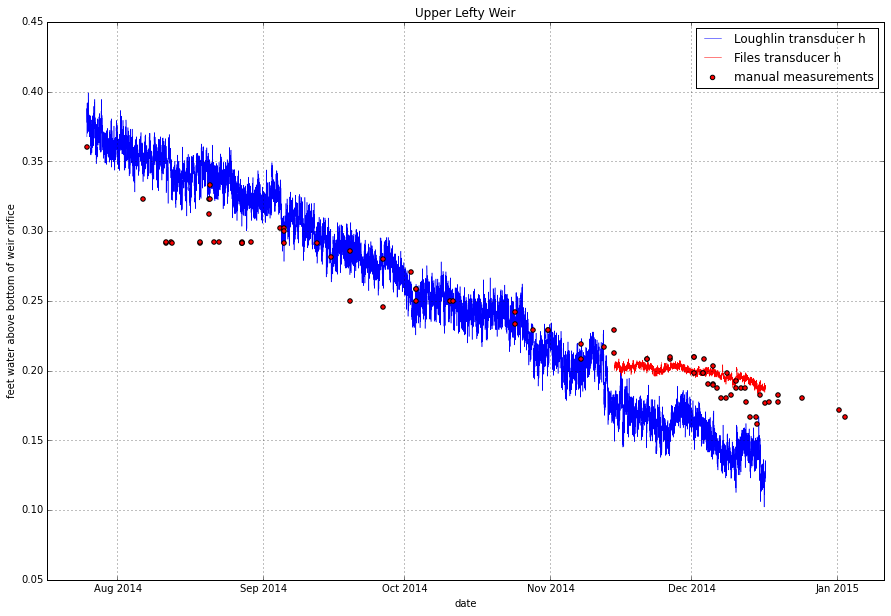

In [50]:
plt.figure()

x = Leftys.index.to_datetime()
y = Leftys['UL_LW_h_ft']

x1 = UL_manual.index.to_datetime()
y1 = UL_manual['UL_vdepth_ft']

y2 = Leftys['UL_JF_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Upper Lefty Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)

Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For 90$^\circ$ v-notch weirs, the equation to calculate discharge from h is:
$$
Q= 1122\cdot h^{\frac{5}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [51]:
Leftys['UL_LW_Q_gpm'] = 1122*Leftys['UL_LW_h_ft']**(2.5)
Leftys['UL_LW_Q_cfs'] = 0.00222800926*Leftys['UL_LW_Q_gpm']
Leftys['UL_JF_Q_gpm'] = 1122*Leftys['UL_JF_h_ft']**(2.5)
Leftys['UL_JF_Q_cfs'] = 0.00222800926*Leftys['UL_JF_Q_gpm']

Plot the resulting discharge values and the manual discharge measurements to see how they compare. 

0.68989565648
0.491013425763
0.694806629965


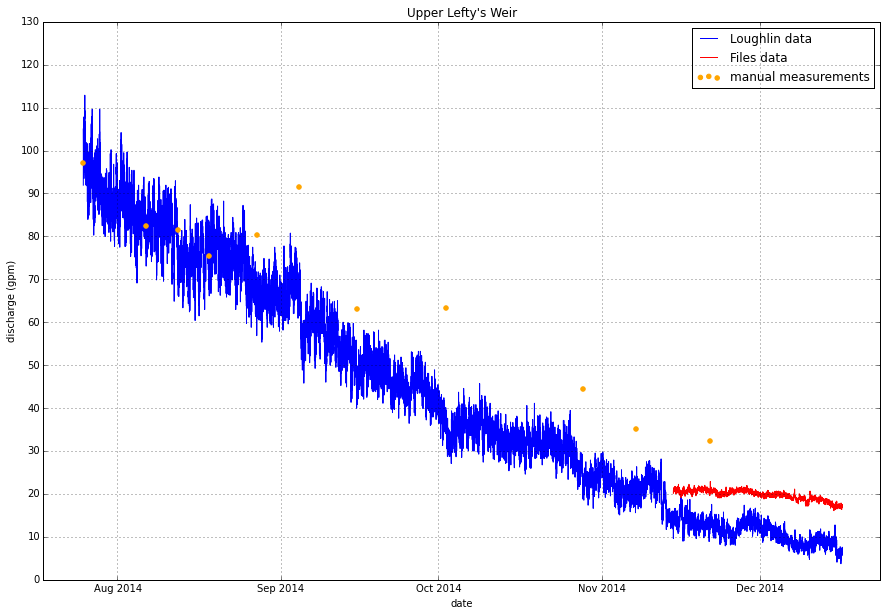

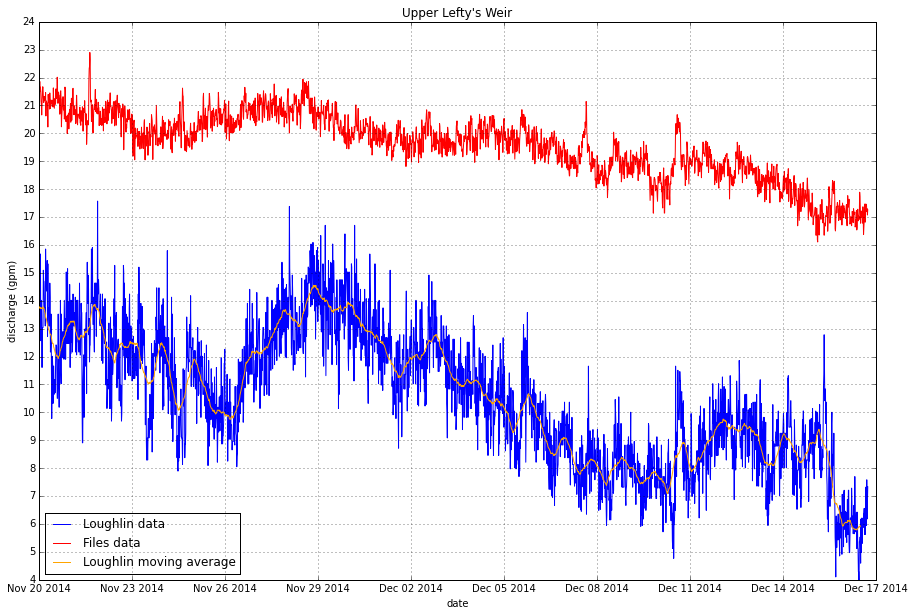

In [53]:
plt.figure()
x = Leftys.index.to_datetime()
y1 = Leftys['UL_LW_Q_gpm']
y2 = Leftys['UL_JF_Q_gpm']
x3 = UL_manual.index.to_datetime()
y3 = UL_manual['UL_bucket_Q_gpm']

print y1.corr(y2, method='pearson')
print y1.corr(y2, method='kendall')
print y1.corr(y2, method='spearman')

y4 = pd.rolling_mean(Leftys['UL_LW_Q_gpm'], window=48, center=True)

plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.scatter(x3,y3, color='orange', zorder=3, label='manual measurements' )
plt.title('Upper Lefty\'s Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()
plt.yticks(np.arange(0, 140.0, 10))
plt.ylim(0.0, 130.0)
plt.legend( scatterpoints=1))

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.plot(x,y4, color='orange', zorder=3, label='Loughlin moving average')
plt.title('Upper Lefty\'s Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()
plt.yticks(np.arange(0, 40.0, 1))
plt.ylim(4.0, 24.0)
plt.xlim('11/20/2014','12/17/2014')
plt.legend(loc=3, scatterpoints=1)

In [54]:
#Leftys = Leftys.drop(['UL_LW_p_cm','dpUL_LW_p_cm', 'maUL_LW_p_cm', 'mstUL_LW_p_cm', 'UL_JF_p_PSI', 'UL_JF_dp_PSI', 'UL_BP_LW_p_cm',
 #                    'UL_LW_p_ft','UL_LW_h_ft', 'UL_JF_p_ft', 'UL_JF_h_ft'],axis=1)

In [55]:
Leftys = nodups(Leftys, Climate)

In [56]:
list(Leftys.columns.values)

['UL_LW_t_C',
 'UL_JF_t_C',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_t_C',
 'UL_BP_LW_p_ft',
 'UL_LW_Q_gpm',
 'UL_LW_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_Q_cfs']

In [57]:
All = pd.merge(Climate, Leftys, right_index=True, left_index=True, how='outer')

In [58]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'UL_LW_t_C',
 'UL_JF_t_C',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_t_C',
 'UL_BP_LW_p_ft',
 'UL_LW_Q_gpm',
 'UL_LW_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_Q_cfs']

### Comparing the Data

[To top of page](#top)

The two datasets are definately different in tems of the amount of small-scale variability.  The Loughlin data show greater variability, perhaps due to an incomplete removal of barometric pressure effects.

                            OLS Regression Results                            
Dep. Variable:            UL_JF_Q_gpm   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     2799.
Date:                Thu, 12 Nov 2015   Prob (F-statistic):               0.00
Time:                        07:07:58   Log-Likelihood:                -3858.6
No. Observations:                3084   AIC:                             7721.
Df Residuals:                    3082   BIC:                             7733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          16.4452      0.065    252.095      

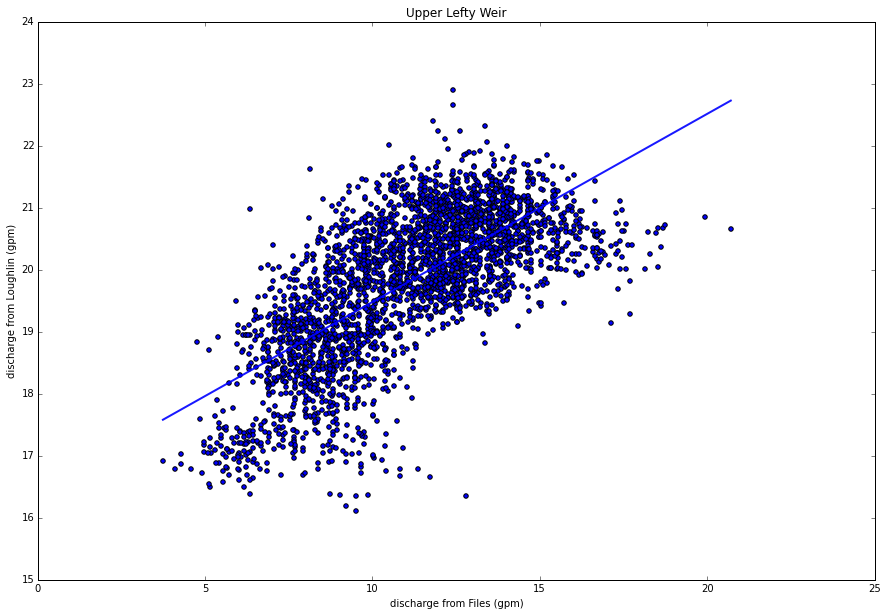

In [59]:
LeftyShortJF = Leftys[np.isfinite(Leftys)]
LeftyShortJF =LeftyShortJF[np.isfinite(LeftyShortJF['UL_LW_Q_gpm'])]
LeftyShortJF =LeftyShortJF[np.isfinite(LeftyShortJF['UL_JF_Q_gpm'])]

x0 = LeftyShortJF['UL_LW_Q_gpm']
x = sm.add_constant(x0)
y = LeftyShortJF['UL_JF_Q_gpm']

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Upper Lefty Weir')
plt.ylabel('discharge from Loughlin (gpm)')
plt.xlabel('discharge from Files (gpm)')

                            OLS Regression Results                            
Dep. Variable:            UL_LW_Q_gpm   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 3.093e+05
Date:                Thu, 12 Nov 2015   Prob (F-statistic):               0.00
Time:                        07:07:59   Log-Likelihood:                -35652.
No. Observations:               11926   AIC:                         7.131e+04
Df Residuals:                   11924   BIC:                         7.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1.678e+06   3017.297    556.144      0.0

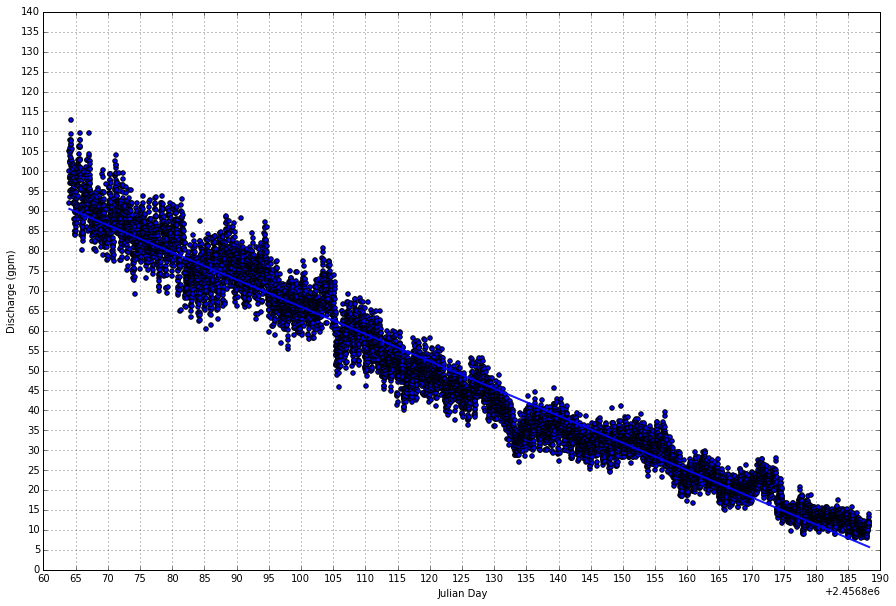

In [60]:
LeftyShortJF = Leftys[np.isfinite(Leftys['UL_LW_Q_gpm'])]

x0 = LeftyShortJF.index.to_julian_date()[:-20*24*4]
x = sm.add_constant(x0)
y = LeftyShortJF['UL_LW_Q_gpm'][:-20*24*4]

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')
plt.xlabel('Julian Day')
plt.ylabel('Discharge (gpm)')
plt.xlim(2456860,2456990)
plt.xticks(np.arange(2456860,2456995, 5))
plt.yticks(np.arange(0,145, 5))
plt.grid()

The long-term seasonal trend in the transducer data show a decrease of discharge of 0.72 gallons per minute per day. The decline in discharge is not perfectly linear, and tapers off as time progresses.

1164
1164
                            OLS Regression Results                            
Dep. Variable:            UL_JF_Q_gpm   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     143.0
Date:                Thu, 12 Nov 2015   Prob (F-statistic):           3.68e-31
Time:                        07:07:59   Log-Likelihood:                -897.03
No. Observations:                1164   AIC:                             1798.
Df Residuals:                    1162   BIC:                             1808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1.288e+05   1.08e+04     11.95

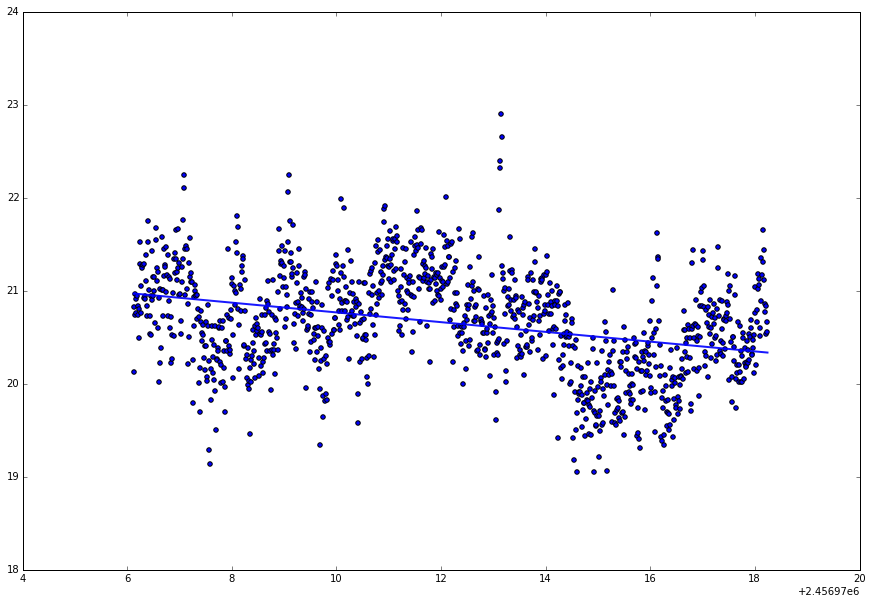

In [61]:
LeftyShortJF = Leftys[np.isfinite(Leftys['UL_JF_Q_gpm'])]

x0 = LeftyShortJF.index.to_julian_date()[:-20*24*4]
x = sm.add_constant(x0)
y = LeftyShortJF['UL_JF_Q_gpm'][:-20*24*4]

print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

In [62]:
#del (Climate,Leftys,LeftyShortJF)

## Lower Lefty's Spring

### Importing and Converting Lower Lefty's Spring Data

[To top of page](#top)

Import the transducer data collected by Loughlin Water at Upper Lefty's Spring weir. These data are nonvented and provide values of absolute head, so barometric pressure must be subtracted to determine the water head above the transducer. These data extend from 12/3/2014 15:30 to 12/19/2014 11:45. The path to the input file can be found in the [data sources](#Data-Sources) section. <a id=lower></a>

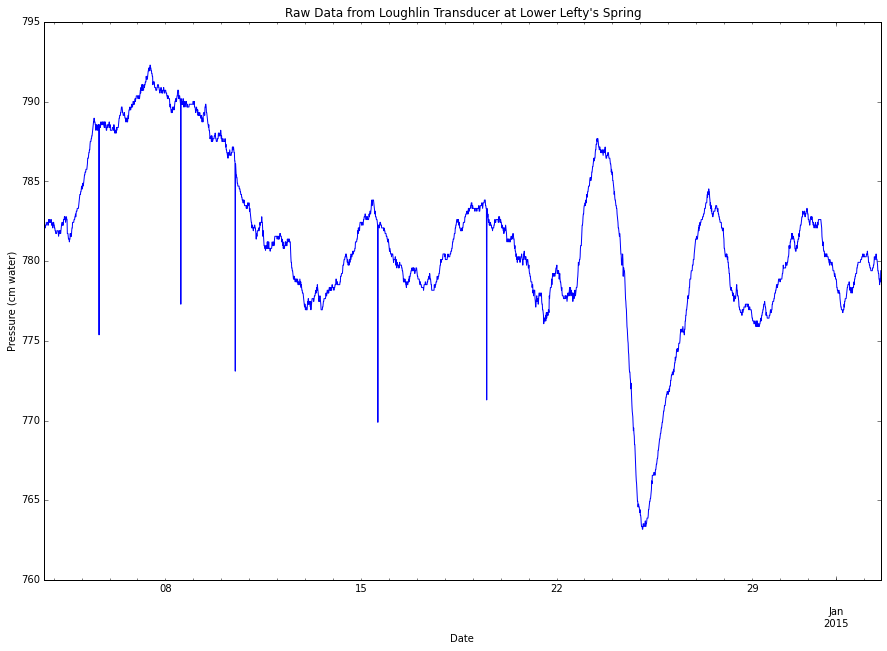

In [63]:
LL_LW = pd.read_csv(Lower_Leftys_Loughlin,
                    index_col=0, skiprows=54, skipfooter=1, parse_dates=True, 
                    names=['dt','LL_LW_p_cm','LL_LW_t_C'], engine='python')
LL_LW['LL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at Lower Lefty\'s Spring')

Remove obvious outliers created when the transducer was not in the water.

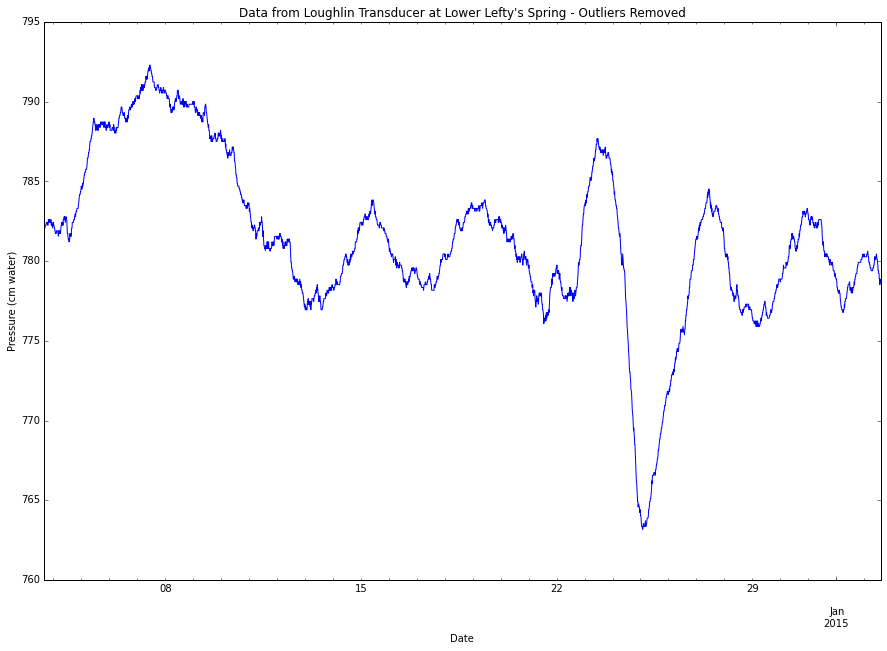

In [64]:
LL_LW = smoother(LL_LW, 'LL_LW_p_cm', 50, 3)
LL_LW['LL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at Lower Lefty\'s Spring - Outliers Removed')

Import the Upper Leftys barometric pressure data to remove barometric influence from the weir transducer data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=leftysbp1></a>

In [65]:
UL_BP_LW = pd.read_csv(Upper_Leftys_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','UL_BP_LW_p_cm','UL_BP_LW_t_C'], 
                    engine='python')

Plot the barometric pressure and the nonvented transducer data to make sure they match.

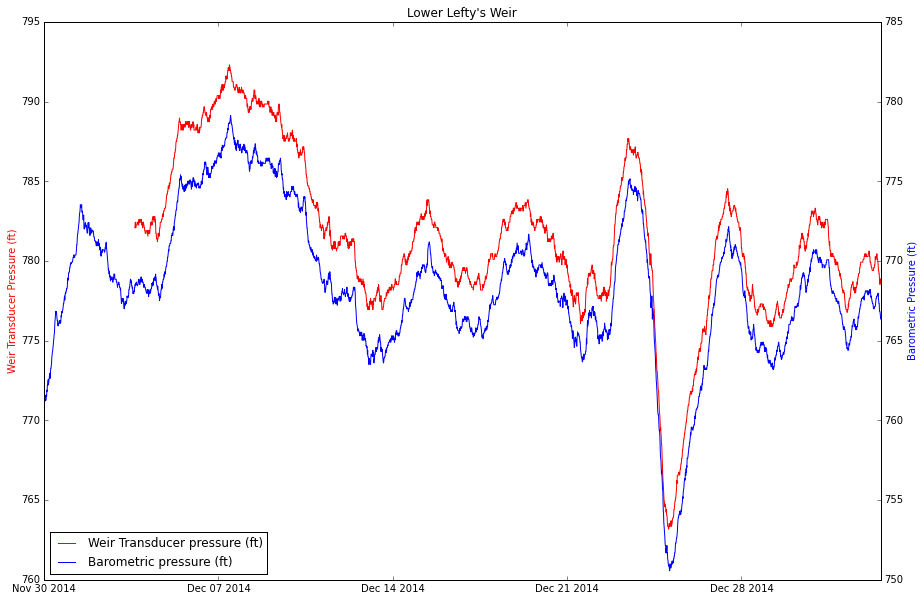

In [66]:
plt.figure()
x1 = LL_LW.index.to_datetime()
y1 = LL_LW['LL_LW_p_cm']

x2 = UL_BP_LW.index.to_datetime()
y2 = UL_BP_LW['UL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('Lower Lefty\'s Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [102]:
LowLeftys = pd.merge(LL_LW, UL_BP_LW, left_index=True, right_index=True, how='outer')
LowLeftys['LL_LW_p_ft'] =(LowLeftys['LL_LW_p_cm'] - LowLeftys['UL_BP_LW_p_cm'])*0.0328084
LowLeftys['UL_BP_LW_p_ft'] = LowLeftys['UL_BP_LW_p_cm']*0.0328084

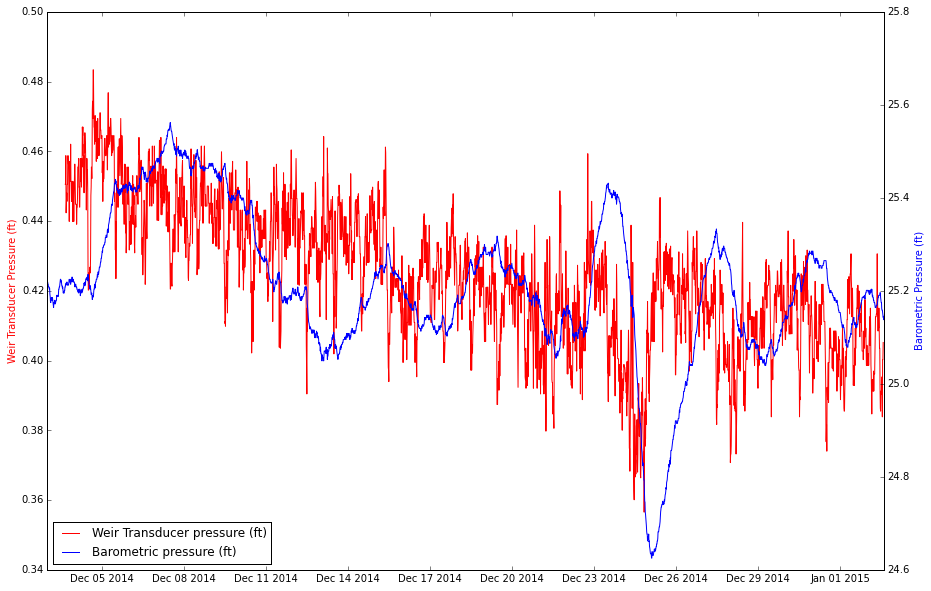

In [103]:
x = LowLeftys.index.to_datetime()
y1 = LowLeftys['LL_LW_p_ft']
y2 = LowLeftys['UL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('12/3/2014',LowLeftys.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

Import data from John Files. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=fileslower></a>

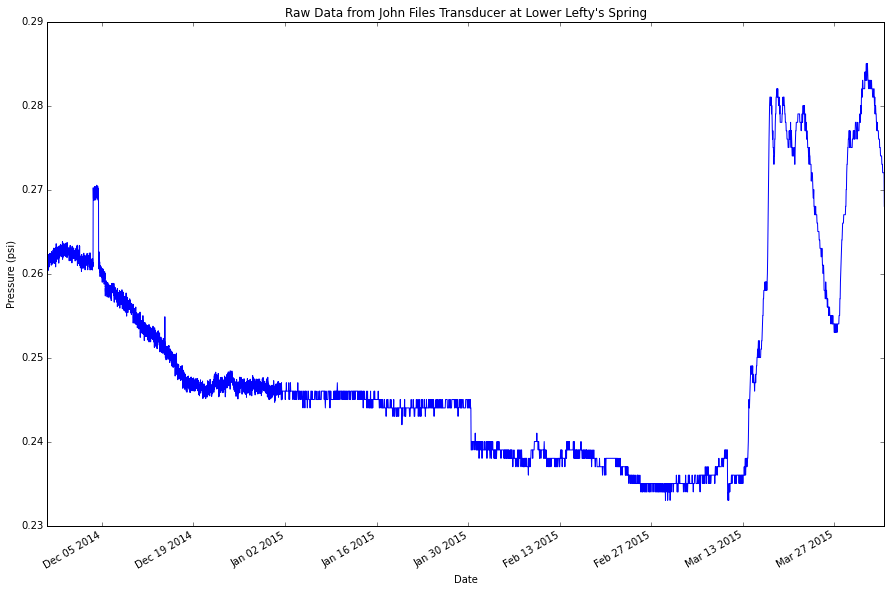

In [104]:
LL_JF = pd.read_csv(Lower_Leftys_John_Files, 
                     index_col=0, skiprows=91, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','LL_JF_p_PSI','LL_JF_t_C'], engine='python')
LL_JF2 = pd.read_csv(Lower_Leftys_John_Files2,
                     index_col=0, skiprows=74, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','LL_JF_p_PSI','LL_JF_t_C'], engine='python')

LL_JF = pd.concat([LL_JF,LL_JF2])
plt.figure()
LL_JF['LL_JF_p_PSI'].plot()
#LL_JF2['LL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Lower Lefty\'s Spring')

In [105]:
LL_JF = jumpfix(LL_JF,'LL_JF_p_PSI',0.005)


C:\Python27\ArcGIS10.3\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


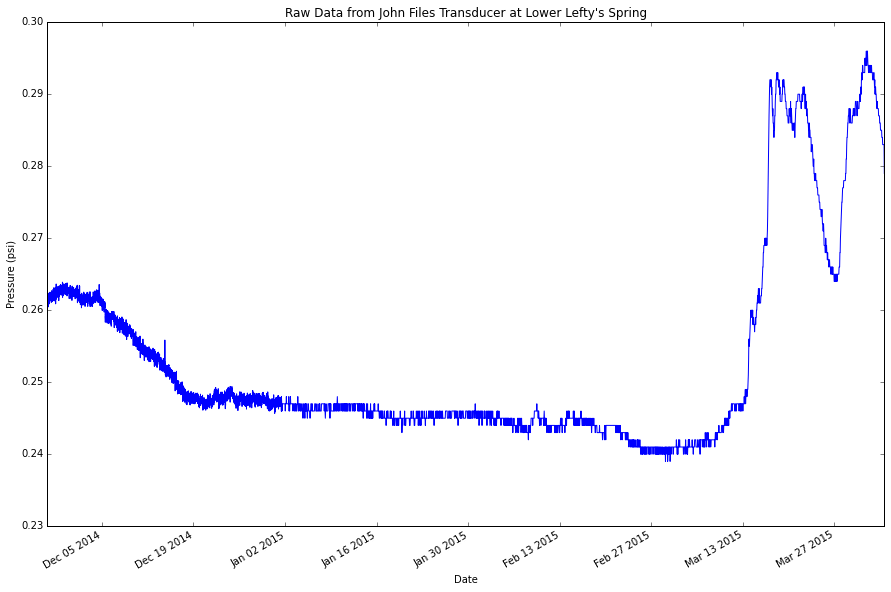

In [106]:
plt.figure()
LL_JF['LL_JF_p_PSI'].plot()
#LL_JF2['LL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Lower Lefty\'s Spring')

Remove outliers from John Files data.

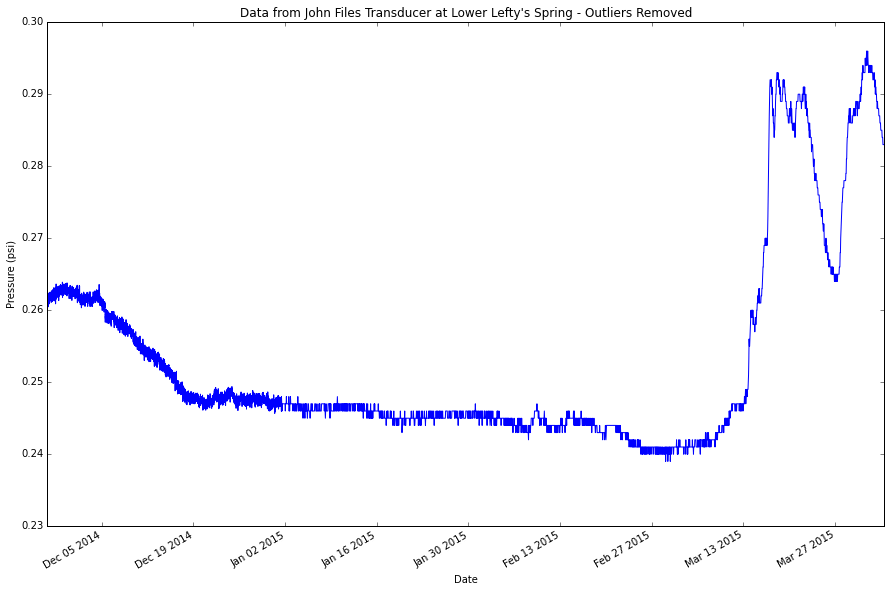

In [107]:
LL_JF = smoother(LL_JF, 'LL_JF_p_PSI', 200, 3)
LL_JF['LL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Data from John Files Transducer at Lower Lefty\'s Spring - Outliers Removed')

Resample and interpolate John Files data to match interval and timing of Loughlin data.

In [108]:
LL_JF = LL_JF.resample('1Min', how='mean')
LL_JF = LL_JF.interpolate(method='time')
LL_JF = LL_JF.resample('15Min', how='mean', base=0)

In [109]:
LowLeftys = pd.merge(LowLeftys, LL_JF, left_index=True, right_index=True, how='outer')

Import the manually readings for Lower Lefty's weir. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=lowerman></a>

In [110]:
LL_manual = pd.read_excel(Lower_Leftys_Manual, 'LowerLeftys', index_col=0, 
                          parse_cols=[0,1], skiprows=0, 
                          names=['date','LL_vdepth_in'], skip_footer=0)
LL_manual['LL_vdepth_ft'] = LL_manual['LL_vdepth_in']/12
LL_manual = LL_manual.sort_index()
LL_manual = LL_manual[ LL_manual.index.to_datetime()>pd.datetime(2014,7,25)]
print LL_manual

                     LL_vdepth_in  LL_vdepth_ft
date                                           
2014-11-21 13:57:00        4.0000      0.333333
2014-11-26 15:30:00        4.0000      0.333333
2014-12-01 13:48:00        3.7500      0.312500
2014-12-01 14:26:00        4.0000      0.333333
2014-12-03 12:48:00        3.7500      0.312500
2014-12-03 12:48:00        3.8400      0.320000
2014-12-03 15:20:00        3.8750      0.322917
2014-12-04 12:00:00        4.0000      0.333333
2014-12-05 12:25:00        4.0000      0.333333
2014-12-05 12:40:00        3.8750      0.322917
2014-12-06 11:10:00        3.6000      0.300000
2014-12-07 08:00:00        3.4800      0.290000
2014-12-08 08:20:00        3.6000      0.300000
2014-12-08 13:07:00        3.8125      0.317708
2014-12-09 11:54:00        3.7500      0.312500
2014-12-10 11:55:00        3.8125      0.317708
2014-12-10 12:53:00        3.6240      0.302000
2014-12-11 11:07:00        3.6240      0.302000
2014-12-12 11:02:00        3.8125      0

In [111]:
LowLeftys.columns

Index([u'LL_LW_p_cm', u'LL_LW_t_C', u'dpLL_LW_p_cm', u'maLL_LW_p_cm',
       u'mstLL_LW_p_cm', u'UL_BP_LW_p_cm', u'UL_BP_LW_t_C', u'LL_LW_p_ft',
       u'UL_BP_LW_p_ft', u'LL_JF_p_PSI', u'LL_JF_t_C', u'deltaLL_JF_p_PSI',
       u'newVal', u'dpLL_JF_p_PSI', u'maLL_JF_p_PSI', u'mstLL_JF_p_PSI'],
      dtype='object')

In [112]:
LowLeftys['LL_JF_p_ft'] = LowLeftys['LL_JF_p_PSI']*2.307
meanDiff = rollmeandiff(LL_manual,'LL_vdepth_ft',LowLeftys,'LL_JF_p_ft',5)
print meanDiff
LowLeftys['LL_JF_h_ft'] = LowLeftys['LL_JF_p_ft'] + meanDiff

-0.277


In [113]:
meanDiff = rollmeandiff(LL_manual,'LL_vdepth_ft',LowLeftys,'LL_LW_p_ft',5)
print meanDiff
LowLeftys['LL_LW_h_ft'] = LowLeftys['LL_LW_p_ft'] + meanDiff

-0.106


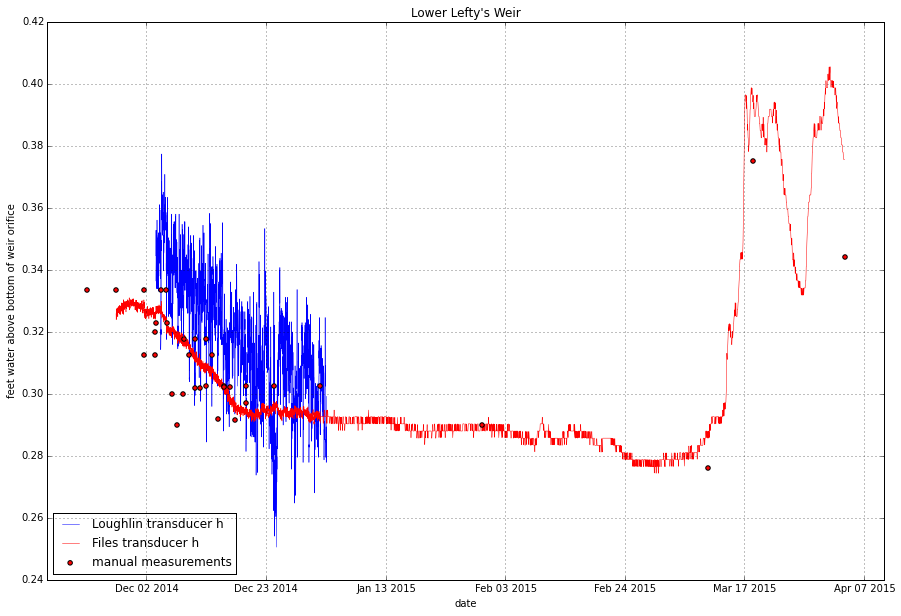

In [117]:
plt.figure()

x = LowLeftys.index.to_datetime()
y = LowLeftys['LL_LW_h_ft']

x1 = LL_manual.index.to_datetime()
y1 = LL_manual['LL_vdepth_ft']

y2 = LowLeftys['LL_JF_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Lower Lefty\'s Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
#plt.yticks(np.arange(0, 1.0, 0.05))
#plt.ylim(0.3, 1.0)
plt.legend(loc=3, scatterpoints=1)


Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For 90$^\circ$ v-notch weirs, the equation to calculate discharge from h is:
$$
Q= 1122\cdot h^{\frac{5}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [118]:
LowLeftys['LL_LW_Q_gpm'] = 1122*LowLeftys['LL_LW_h_ft']**2.5
LowLeftys['LL_JF_Q_gpm'] = 1122*LowLeftys['LL_JF_h_ft']**2.5
LowLeftys['LL_JF_Q_cfs'] = 0.00222800926*LowLeftys['LL_JF_Q_gpm']
LowLeftys['LL_LW_Q_cfs'] = 0.00222800926*LowLeftys['LL_LW_Q_gpm']

In [124]:
plt.figure()
x = LowLeftys.index.to_datetime()
y1 = LowLeftys['LL_LW_Q_gpm']
y2 = LowLeftys['LL_JF_Q_gpm']

y3 = pd.rolling_mean(LowLeftys['LL_LW_Q_gpm'], window=86, center=True)
y4 = pd.rolling_mean(LowLeftys['LL_JF_Q_gpm'], window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.plot(x,y3, color='green', linewidth=2, zorder=3, label='Loughlin moving average')
plt.plot(x,y4, color='orange',  linewidth=2, zorder=4, label='Files moving average')
plt.title('Lower Lefty\'s Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend()

KeyError: 'LL_LW_Q_gpm'

In [120]:
LowLeftysDrop = ['LL_LW_p_cm', 'dpLL_LW_p_cm', 'maLL_LW_p_cm', 'mstLL_LW_p_cm', 'UL_BP_LW_p_cm', 'LL_LW_p_ft', 
                            'LL_JF_p_PSI', 'LL_JF_dp_PSI', 'dpLL_JF_p_PSI', 'maLL_JF_p_PSI', 'mstLL_JF_p_PSI', 
                            'LL_JF_p_ft', 'LL_JF_h_ft', 'LL_LW_h_ft', 'UL_BP_LW_t_C', 'UL_BP_LW_p_ft']


In [121]:
LowLeftys = nodups(LowLeftys,All)

In [122]:
list(LowLeftys.columns.values)

[]

Merge existing datasets.

In [85]:
All = pd.merge(All, LowLeftys, left_index=True, right_index=True, how='outer')

In [86]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'UL_LW_t_C',
 'UL_JF_t_C',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_t_C',
 'UL_BP_LW_p_ft',
 'UL_LW_Q_gpm',
 'UL_LW_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_Q_cfs',
 'LL_LW_t_C',
 'LL_JF_t_C',
 'LL_LW_Q_gpm',
 'LL_JF_Q_gpm',
 'LL_JF_Q_cfs',
 'LL_LW_Q_cfs']

## Hidden Lake Spring

### Importing and Converting Hidden Lake Spring Data

[To top of page](#top)

Import the Hidden Lake weir data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hidden></a>

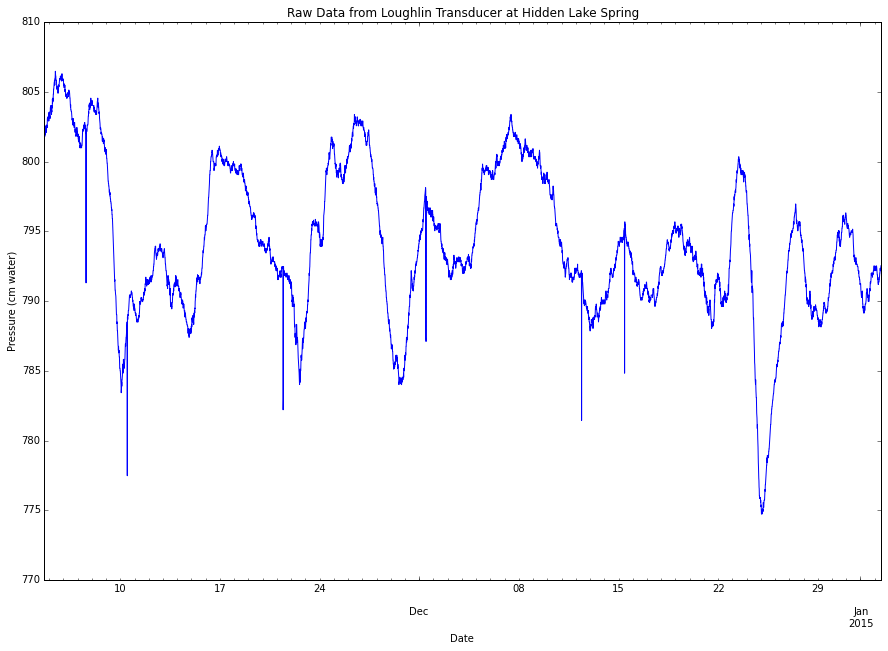

In [87]:
HL_LW = pd.read_csv(Hidden_Lake_Loughlin, 
                    index_col=0, skiprows=53, skipfooter=1, parse_dates=True, 
                    usecols=[0,1,2], names=['dt','HL_LW_p_cm','HL_LW_t_C'], engine='python')

HL_LW['HL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at Hidden Lake Spring')

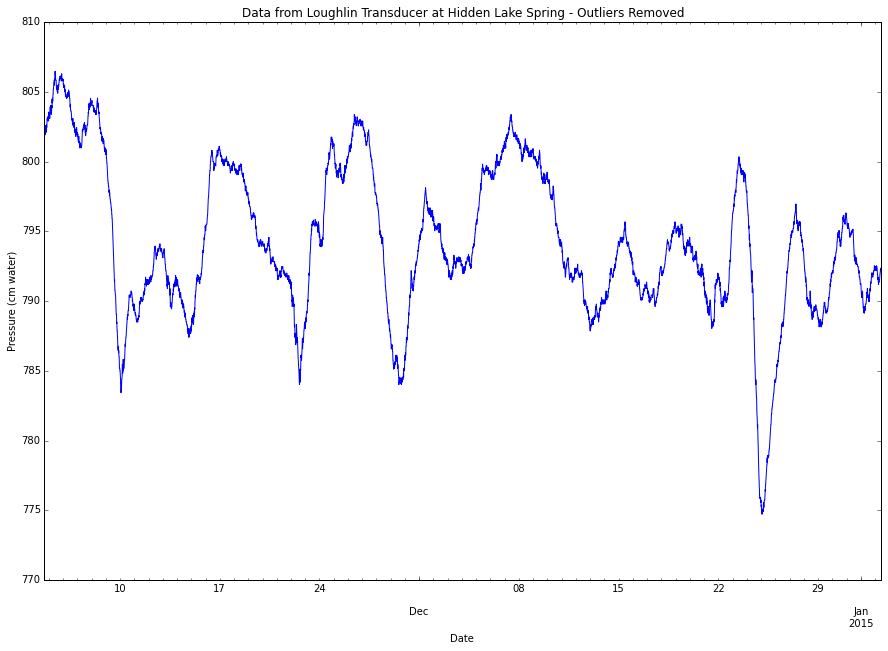

In [88]:
HL_LW = smoother(HL_LW, 'HL_LW_p_cm', 50, 3)
HL_LW = smoother(HL_LW, 'HL_LW_p_cm', 50, 3) # passed twice
HL_LW['HL_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at Hidden Lake Spring - Outliers Removed')

Import the Hidden Lake barometric pressure data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hiddenbp></a>

In [89]:
HL_BP_LW = pd.read_csv(Hidden_Lake_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','HL_BP_LW_p_cm','HL_BP_LW_t_C'], 
                    engine='python')

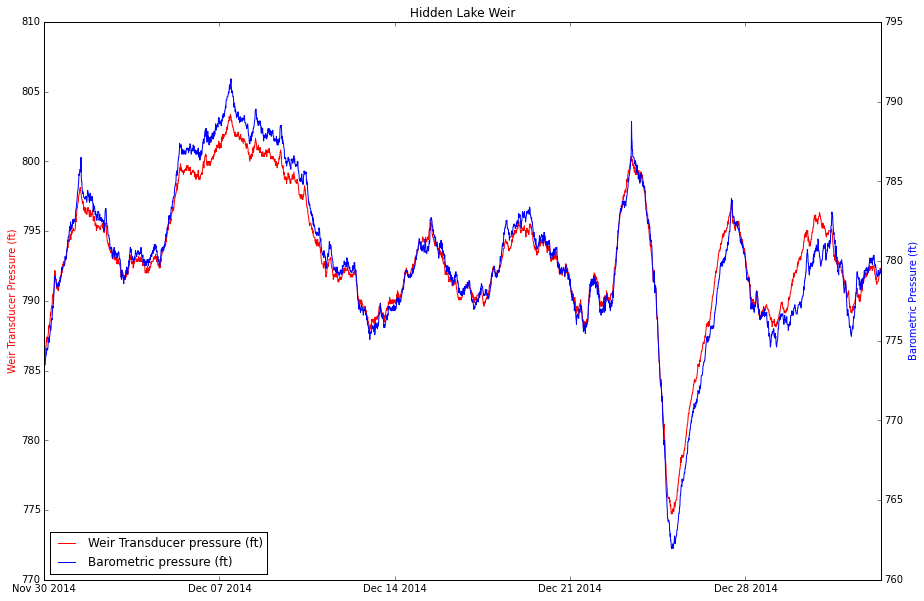

In [90]:
plt.figure()
x1 = HL_LW.index.to_datetime()
y1 = HL_LW['HL_LW_p_cm']

x2 = HL_BP_LW.index.to_datetime()
y2 = HL_BP_LW['HL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('Hidden Lake Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [91]:
HidLake = pd.merge(HL_LW, HL_BP_LW, left_index=True, right_index=True, how='outer')

HidLake['HL_LW_p_ft'] =(HidLake['HL_LW_p_cm'] - HidLake['HL_BP_LW_p_cm'])*0.0328084
HidLake['HL_BP_LW_p_ft'] = HidLake['HL_BP_LW_p_cm']*0.0328084

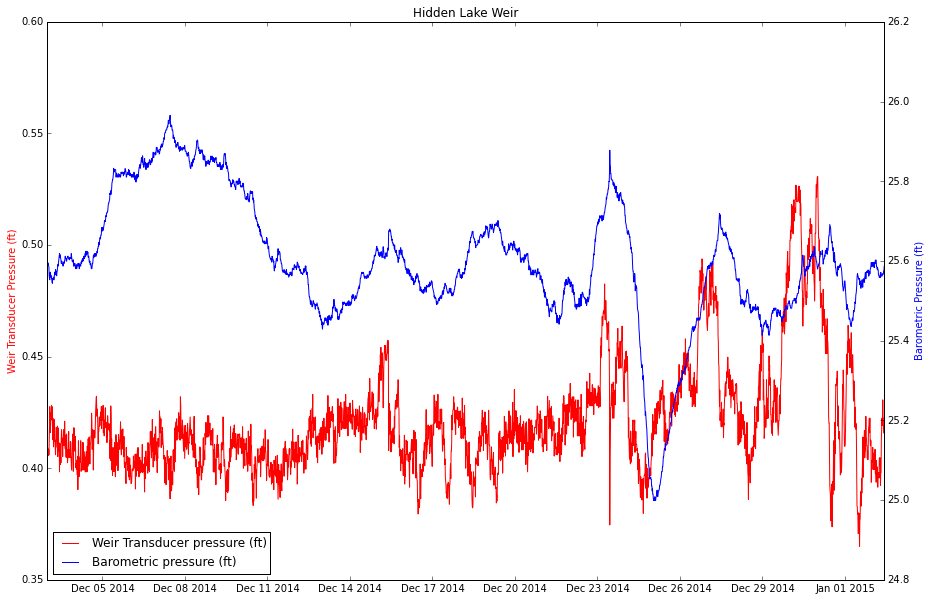

In [92]:
x = HidLake.index.to_datetime()
y1 = HidLake['HL_LW_p_ft']
y2 = HidLake['HL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('12/3/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

Import the Hidden Lake wier data from John Files. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hiddenfiles></a>

In [93]:
HL_JF = pd.read_csv(Hidden_Lake_John_Files, 
                     index_col=0, skiprows=89, skipfooter=1, usecols=[0,2,3], parse_dates=True, 
                     names=['dt','HL_JF_p_PSI','HL_JF_t_C'], engine='python')

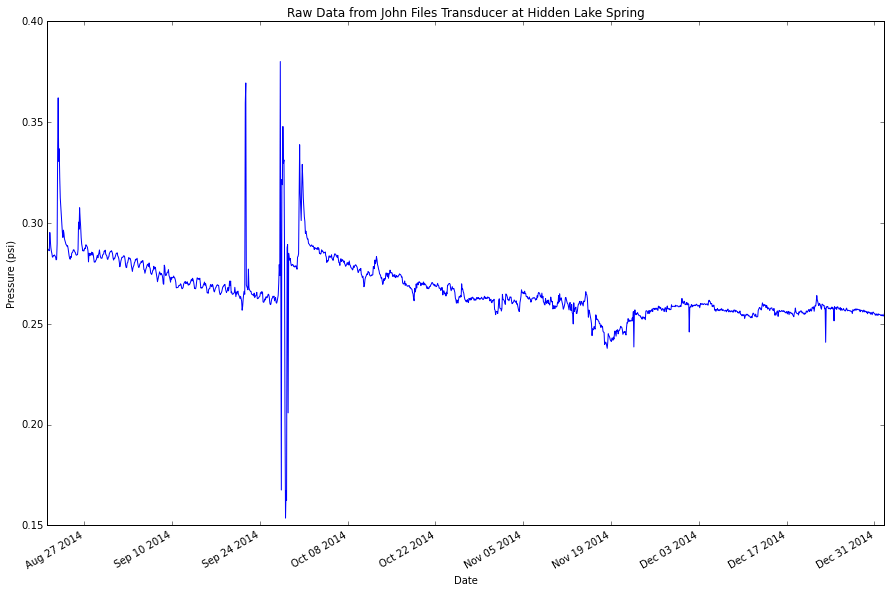

In [94]:
HL_JF['HL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Raw Data from John Files Transducer at Hidden Lake Spring')

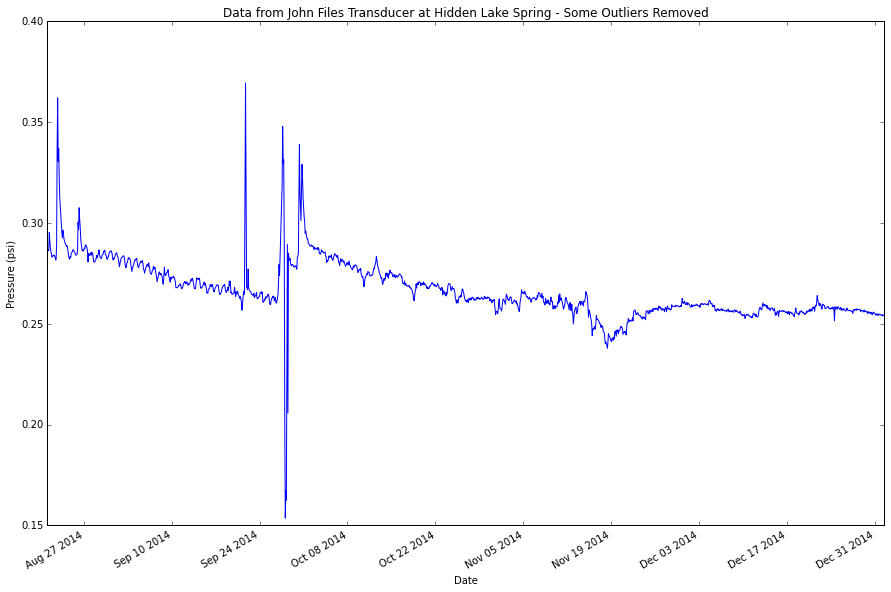

In [95]:
HL_JF = smoother(HL_JF, 'HL_JF_p_PSI', 100, 3)
HL_JF['HL_JF_p_PSI'].plot()
plt.ylabel('Pressure (psi)')
plt.xlabel('Date')
plt.title('Data from John Files Transducer at Hidden Lake Spring - Some Outliers Removed')

In [96]:
HL_JF = HL_JF.resample('1Min', how='mean')
HL_JF = HL_JF.interpolate(method='time')
HL_JF = HL_JF.resample('15Min', how='mean', base=0)

In [97]:
HidLake = pd.merge(HidLake, HL_JF, left_index=True, right_index=True, how='outer')

Import the manual data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hiddenman></a>

In [98]:
HL_manual = pd.read_excel(Hidden_Lake_Manual, 'HiddenLakeWeir', index_col=0, 
                          parse_cols=[0,1,2], skiprows=0, na_values=['NA',''],
                          names=['date','HL_vdepth_in','HL_depth_in'], skip_footer=0, parse_dates=True)
HL_manual['HL_offset_ft'] = (HL_manual['HL_depth_in']/12-HL_manual['HL_vdepth_in']/12).mean()
HL_manual['HL_depth_ft'] = HL_manual['HL_vdepth_in']/12+HL_manual['HL_offset_ft']
HL_manual = HL_manual.sort_index()
HL_manual = HL_manual[ HL_manual.index.to_datetime()>pd.datetime(2014,7,25)]
print HL_manual

                     HL_vdepth_in  HL_depth_in  HL_offset_ft  HL_depth_ft
date                                                                     
2014-08-18 11:00:00        2.5000          NaN      0.167969     0.376302
2014-08-20 09:20:00        2.7500          NaN      0.167969     0.397135
2014-08-20 11:00:00        2.7500          NaN      0.167969     0.397135
2014-08-22 11:00:00        2.5000          NaN      0.167969     0.376302
2014-08-27 11:00:00        2.6250          NaN      0.167969     0.386719
2014-08-29 09:36:00        2.9000          NaN      0.167969     0.409635
2014-08-29 09:36:00        2.7500          NaN      0.167969     0.397135
2014-09-04 11:00:00        2.8125          NaN      0.167969     0.402344
2014-09-05 10:23:00        2.7500          NaN      0.167969     0.397135
2014-09-12 11:55:00        2.6250          NaN      0.167969     0.386719
2014-09-15 11:00:00        2.3750       4.4375      0.167969     0.365885
2014-09-19 08:15:00        2.5000     

In [99]:
meanDiff = rollmeandiff(HL_manual,'HL_depth_ft',HidLake,'HL_LW_p_ft',5)
print meanDiff
HidLake['HL_LW_h_ft'] = HidLake['HL_LW_p_ft'] + meanDiff

-0.074


In [100]:
HidLake['HL_JF_p_ft'] = HidLake['HL_JF_p_PSI']*2.307
meanDiff = rollmeandiff(HL_manual,'HL_depth_ft',HidLake,'HL_JF_p_ft',5)
print meanDiff
HidLake['HL_JF_h_ft'] = HidLake['HL_JF_p_ft'] + meanDiff

-0.247


In [ ]:
plt.figure()

x = HidLake.index.to_datetime()
y = HidLake['HL_LW_h_ft']

x1 = HL_manual.index.to_datetime()
y1 = HL_manual['HL_depth_ft']

y2 = HidLake['HL_JF_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='Files transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Lower Lefty\'s Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)


Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For 90$^\circ$ v-notch weirs, the equation to calculate discharge from h is:
$$
Q= 1122\cdot h^{\frac{5}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [ ]:
HidLake['HL_LW_Q_gpm'] = 1122*HidLake['HL_LW_h_ft']**2.5
HidLake['HL_JF_Q_gpm'] = 1122*HidLake['HL_JF_h_ft']**2.5
HidLake['HL_JF_Q_cfs'] = 0.00222800926*HidLake['HL_JF_Q_gpm']
HidLake['HL_LW_Q_cfs'] = 0.00222800926*HidLake['HL_LW_Q_gpm']

In [ ]:
plt.figure()
x = HidLake.index.to_datetime()
y1 = HidLake['HL_LW_Q_gpm']
y2 = HidLake['HL_JF_Q_gpm']

y3 = pd.rolling_mean(HidLake['HL_LW_Q_gpm'], window=86, center=True)
y4 = pd.rolling_mean(HidLake['HL_JF_Q_gpm'], window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='Files data')
plt.plot(x,y3, color='orange', zorder=3, label='Loughlin moving average')
plt.plot(x,y4, color='purple', zorder=4, label='Files moving average')
plt.title('Hidden Lake Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend()

In [ ]:

x1 = HidLake.index.to_datetime()
x2 = All.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = All['USU_SF_PPT_in']


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Precipitation (in)', color='b') 
ax2.plot(x2,y2,c='b',label='USU South Fork Precip')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)

plt.show()

In [ ]:
x1 = HidLake.index.to_datetime()
x2 = HidLake.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = HidLake['HL_LW_t_C']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Temperature (C)', color='b') 
ax2.plot(x2,y2,c='b',label='Hidden Lake Water Temperature')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)

plt.show()

In [ ]:
x1 = HidLake.index.to_datetime()
x2 = All.index.to_datetime()

y1 = HidLake['HL_JF_Q_gpm']
y2 = All['USU_SF_AD_h_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('Hidden Lake Weir')
ax1.plot(x1,y1,c='r',label='Hidden Lake Weir Discharge')
ax1.set_ylabel('Discharge (gpm)', color='r') 
ax2.set_ylabel('Height (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Little Bear River Gage')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('8/23/2014',HidLake.index.to_datetime()[-1])
ax1.legend(h1+h2, l1+l2, loc=0)
plt.grid(which='major', axis='both')
plt.show()

In [ ]:
aHidLake = HidLake[(HidLake.index.to_datetime() < pd.datetime(2014,9,20))&(HidLake.index.to_datetime() > pd.datetime(2014,8,28))]
x0 = aHidLake.index.to_julian_date()
y = aHidLake['HL_JF_Q_gpm']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Hidden Lake Seasonal Decline')
plt.ylabel('Discharge (gpm)')
plt.xlabel('Julian Day')

In [ ]:
bHidLake = HidLake[(HidLake.index.to_datetime() < pd.datetime(2014,11,14))&(HidLake.index.to_datetime() > pd.datetime(2014,10,6))]
x0 = bHidLake.index.to_julian_date()
y = bHidLake['HL_JF_Q_gpm']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Hidden Lake Seasonal Decline')
plt.ylabel('Discharge (gpm)')
plt.xlabel('Julian Day')

In [ ]:
HidLake = nodups(HidLake,All)

In [ ]:
list(HidLake.columns.values)

In [ ]:
All = pd.merge(All, HidLake, left_index=True, right_index=True, how='outer')

In [ ]:
#del (HidLake,HL_JF,HL_LW)

In [ ]:
list(All.columns.values)

## North Boundary Weir

### Importing and Converting North Boundary Weir Data

[To top of page](#top)

Import North Boundary weir data from Loughlin. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=nb></a>

In [ ]:
NB_LW = pd.read_csv(North_Boundary_Loughlin,
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, 
                    names=['dt','NB_LW_p_cm','NB_LW_t_C'], engine='python',na_values='' )

NB_LW['NB_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Raw Data from Loughlin Transducer at North Boundary')

In [ ]:
NB_LW['NB_LW_dp_cm'] = NB_LW['NB_LW_p_cm'].diff()
NB_LW_Jump = NB_LW[abs(NB_LW['NB_LW_dp_cm'])>10][2:]
NB_LW_Jump['diff'] = abs(NB_LW['NB_LW_dp_cm'][2:]).diff()
mdiff = (abs(NB_LW_Jump['diff'][1])+abs(NB_LW_Jump['diff'][3]))/2
print mdiff
print NB_LW_Jump

In [ ]:
for i in NB_LW.index:
    if i >= NB_LW_Jump.index[1] and i <= NB_LW_Jump.index[2]:
        NB_LW['NB_LW_p_cm'][i]=NB_LW['NB_LW_p_cm'][i]+mdiff
    else:
        NB_LW['NB_LW_p_cm'][i] = NB_LW['NB_LW_p_cm'][i]

NB_LW['NB_LW_p_cm'].plot()
plt.ylabel('Pressure (cm)')
plt.xlabel('Date')
plt.title('Data from Loughlin Water Transducer at North Boundary Weir - Offsets Removed')

In [ ]:
NB_LW = smoother(NB_LW, 'NB_LW_p_cm', 50, 3)
NB_LW['NB_LW_p_cm'].plot()
plt.ylabel('Pressure (cm water)')
plt.xlabel('Date')
plt.title('Data from Loughlin Transducer at North Boundary Weir - Outliers Removed')

Import the barometric pressure data from the Hidden Lake weir barometer (north side barometer), maintained by Loughlin. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=nbbp></a>

In [ ]:
HL_BP_LW = pd.read_csv(Hidden_Lake_Barometer_Loughlin, 
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','HL_BP_LW_p_cm','HL_BP_LW_t_C'], 
                    engine='python')

In [ ]:
plt.figure()
x1 = NB_LW.index.to_datetime()
y1 = NB_LW['NB_LW_p_cm']

x2 = HL_BP_LW.index.to_datetime()
y2 = HL_BP_LW['HL_BP_LW_p_cm']

fig, ax1 = plt.subplots()
plt.title('North Boundary Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [ ]:
NBound = pd.merge(NB_LW, HL_BP_LW, left_index=True, right_index=True, how='outer')
NBound['NB_LW_p_ft'] =(NBound['NB_LW_p_cm'] - NBound['HL_BP_LW_p_cm'])*0.0328084
NBound['HL_BP_LW_p_ft'] = NBound['HL_BP_LW_p_cm']*0.0328084

In [ ]:
x = NBound.index.to_datetime()
y1 = NBound['NB_LW_p_ft']
y2 = NBound['HL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title('North Boundary Weir')
ax1.plot(x,y1,c='r',label='Weir Transducer pressure (ft)')
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='r') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_xlim('11/2/2014',x[-1])
ax1.xaxis.set_minor_locator(dates.DayLocator())
ax1.xaxis.set_major_locator(dates.WeekdayLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b %d'))
ax1.legend(h1+h2, l1+l2, loc=0)
ax1.xaxis_date()
ax1.autoscale_view()
ax1.grid(which='minor')
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

Import the UGS data from the North Boundary weir. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=nbugs></a>

In [ ]:
NB_US = pd.read_csv(North_Boundary_UGS, 
                     index_col=0, skiprows=17, skipfooter=1, parse_dates={'dt':[0,1]}, 
                     names=['date','time','ms','NB_US_p_ft','NB_US_t_C'], engine='python')
NB_US['NB_US_p_ft'].plot()
plt.title('North Boundary Weir')
plt.ylabel('Pressure (ft)')

Import manual data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=northman></a>

In [ ]:
NB_manual = pd.read_excel(North_Boundary_Manual, 'NorthBoundWeir', index_col=0, 
                          parse_cols=[0,1,2], skiprows=0, na_values=['NA',''],
                          names=['date','NB_vdepth_in','NB_depth_in'], skip_footer=0, parse_dates=True)
NB_manual['NB_offset_ft'] = (NB_manual['NB_depth_in']/12-NB_manual['NB_vdepth_in']/12).mean()
NB_manual['NB_depth_ft'] = NB_manual['NB_vdepth_in']/12+NB_manual['NB_offset_ft']
NB_manual = NB_manual.sort_index()
NB_manual = NB_manual[ NB_manual.index.to_datetime()>pd.datetime(2014,7,25)]
print NB_manual

In [ ]:
meanDiff = rollmeandiff(NB_manual,'NB_depth_ft',NBound,'NB_LW_p_ft',5)
print meanDiff
NBound['NB_LW_h_ft'] = NBound['NB_LW_p_ft'] + meanDiff

In [ ]:
NBound = pd.merge(NBound, NB_US, left_index=True, right_index=True, how='outer')

In [ ]:
NBound['HL_BP_LW_p_ft']=NBound['HL_BP_LW_p_cm']/2.54/12
meanDiff = rollmeandiff(NBound,'NB_US_p_ft',NBound,'HL_BP_LW_p_ft',5)
print meanDiff
NBound['NB_US_p_adj_ft'] = NBound['NB_US_p_ft'] - meanDiff

In [ ]:
plt.figure()
x1 = NBound.index.to_datetime()

y1 = NBound['NB_US_p_adj_ft']
y2 = NBound['HL_BP_LW_p_ft']

fig, ax1 = plt.subplots()
plt.title('North Boundary Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Weir Transducer pressure (ft)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Weir Transducer Pressure (ft)', color='g') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x2,y2,c='b',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [ ]:
NBound['NB_US_p_adj_noBP_ft']=NBound['NB_US_p_adj_ft']-NBound['HL_BP_LW_p_ft']

In [ ]:
meanDiff = rollmeandiff(NB_manual,'NB_depth_ft',NBound,'NB_US_p_adj_noBP_ft',5)
print meanDiff
NBound['NB_US_h_ft'] = NBound['NB_US_p_adj_noBP_ft'] + meanDiff

In [ ]:
plt.figure()

x = NBound.index.to_datetime()
y = NBound['NB_LW_h_ft']

x1 = NB_manual.index.to_datetime()
y1 = NB_manual['NB_depth_ft']

y2 = NBound['NB_US_h_ft']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer h')
plt.plot(x, y2, zorder=2, c='red', linewidth=0.5, label='UGS transducer h')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('North Boundary Weir')
plt.ylabel('feet water above bottom of weir orifice')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)


Once the transducer data were aligned with manual readings, we converted the height of water above the bottom of the weir orifice to discharge in both gpm and cfs.

To do this, we used equations from: U.S. Bureau of Reclamation, 2001, Water Measurement Manual - A water resources technical publication: online, http://www.usbr.gov/pmts/hydraulics_lab/pubs/wmm/.

For Cipoletti (trapezoidal) weirs, the equation to calculate discharge from h is:
$$
Q= 1511\cdot h^{\frac{3}{2}}
$$
<ul>
  <li>h = feet above bottom of weir orifice</li>
  <li>Q = discharge in gpm</li>
</ul>

In [ ]:
NBound['NB_US_Q_gpm']=(NBound['NB_US_h_ft']**1.5)*1511
NBound['NB_LW_Q_gpm']=(NBound['NB_LW_h_ft']**1.5)*1511
NBound['NB_US_Q_cfs']=0.00222800926*NBound['NB_US_Q_gpm']
NBound['NB_LW_Q_cfs']=0.00222800926*NBound['NB_LW_Q_gpm']

In [ ]:
plt.figure()
x = NBound.index.to_datetime()
y1 = NBound['NB_LW_Q_gpm']
y2 = NBound['NB_US_Q_gpm']

y3 = pd.rolling_mean(y1, window=86, center=True)
y4 = pd.rolling_mean(y2, window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='UGS data')
plt.title('North Boundary Weir')
plt.ylabel('discharge (gpm)')
plt.xlabel('date')
plt.grid()

plt.legend()

In [ ]:
plt.figure()
x1 = NBound.index.to_datetime()

y1 = NBound['NB_LW_Q_cfs']
y2 = NBound['NB_LW_t_C']

fig, ax1 = plt.subplots()
plt.title('North Boundary Weir')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Discharge (cfs)')
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylim(0,3)
ax2.set_ylim(0,18)
ax1.set_ylabel('Discharge (cfs)', color='g') 
ax2.set_ylabel('Temperature (deg C)', color='b') 
ax2.plot(x1,y2,c='b',label='Temperature (deg C)')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

plt.show()

In [ ]:
plt.figure()
x = NBound.index.to_datetime()
y1 = NBound['NB_LW_Q_cfs']
y2 = NBound['NB_US_Q_cfs']

y3 = pd.rolling_mean(y1, window=86, center=True)
y4 = pd.rolling_mean(y2, window=48, center=True)

plt.figure()
plt.plot(x,y1, color='blue', zorder=1, label='Loughlin data')
plt.plot(x,y2, color='red', zorder=2, label='UGS data')
plt.title('North Boundary Weir')
plt.ylabel('discharge (cfs)')
plt.xlabel('date')
plt.grid()

plt.legend()

In [ ]:
NBound = nodups(NBound,All)

In [ ]:
list(NBound.columns.values)

In [ ]:
All = pd.merge(All, NBound, left_index=True, right_index=True, how='outer')

In [ ]:
#del (NB_LW,NBound)

## Wells

[Hidden Lake Well](#Hidden-Lake-Well)
[Exploration Well 2](#Exploration-Well-2)
[Aquifer Test Hydrographs](#Aquifer-Test-Hydrographs)

### Hidden Lake Well

[To Top](#top)

This is the pumping well. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hlw></a>

In [ ]:
HLW = pd.read_excel(Hidden_Lake_Well, 'PowderMt-01-01-2014', index_col=0, 
                  skiprows=5, skipfooter=0, parse_cols=[0,2,3],
                  names=['date','HLW_h_ft','HLW_Q_gpm'])

In [ ]:
HLW['HLW_h_ft'].plot()
plt.title('Hidden Lake (Pumping) Well')
plt.ylabel('Depth (ft)')

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=hlwman></a>

In [ ]:
HLWM = pd.read_excel(Hidden_Lake_Well_Manual, 'HiddenLakeWell', index_col=0, 
                     skiprows=0, parse_cols=[0,1], names=['date','hlw_dtw_man_ft'])
HLWM['HLWM_wl_elev'] = 8904-HLWM['hlw_dtw_man_ft']

x1 = HLWM.index.to_datetime()
y1 = HLWM['HLWM_wl_elev']

plt.figure()
plt.scatter(x1,y1)

In [ ]:
meanDiff = rollmeandiff(HLWM,'HLWM_wl_elev',HLW,'HLW_h_ft',2)
print meanDiff
HLW['HLW_wl_elev_ft'] = HLW['HLW_h_ft'] + meanDiff

In [ ]:
plt.figure()

x = HLW.index.to_datetime()
y = HLW['HLW_wl_elev_ft']

x1 = HLWM.index.to_datetime()
y1 = HLWM['HLWM_wl_elev']

plt.plot(x, y, zorder=1, c='blue', linewidth=0.5, label='Loughlin transducer wl elevation')
plt.scatter(x1, y1, c='red', zorder=3, label='manual measurements')
plt.title('Hidden Lake (Pumping) Well')
plt.ylabel('water level elevation (ft amsl)')
plt.xlabel('date')
plt.grid()
plt.legend(scatterpoints=1)

In [ ]:
plt.figure()

x1 = HLW.index.to_datetime()
y1 = HLW['HLW_wl_elev_ft']

x2 = HLW.index.to_datetime()
y2 = HLW['HLW_Q_gpm']


fig, ax1 = plt.subplots()
plt.title('Hidden Lake (Pumping) Well')
ax2 = ax1.twinx()
ax1.plot(x1,y1,c='g',label='Water Level Elevation', zorder=1)
ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Water Level Elevation (ft amsl)', color='g') 
ax2.set_ylabel('Pumping Rate (gpm)', color='b') 
ax2.plot(x2,y2,c='b',label='Pumping Rate', zorder=2)
#plt.gca().invert_yaxis()
ax1.set_ylim(7860,8160)
ax2.set_ylim(0,400)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=7)


plt.show()

In [ ]:
y = HLW['HLW_wl_elev_ft'][HLW.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x0 = HLW.index.to_julian_date()[HLW.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x = sm.add_constant(x0)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Pumping Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

In [ ]:
y = HLWM['HLWM_wl_elev'][HLWM.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x0 = HLWM.index.to_julian_date()[HLWM.index.to_datetime() < pd.datetime(2014,12,2,0,0)]
x = sm.add_constant(x0)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Pumping Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

In [ ]:
HLW = HLW.resample('1Min', how='mean')
HLW = HLW.interpolate(method='time')
HLW = HLW.resample('5Min', how='mean')

In [ ]:
HLW15 = HLW.resample('15Min', how='mean')

In [ ]:
All=pd.merge(All, HLW15, left_index=True, right_index=True, how='outer')

In [ ]:
list(All.columns.values)

### Exploration Well 2

[To Top](#top)

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=exw></a>

In [ ]:
EXW = pd.read_csv(Exploration_Well_2, index_col=0, parse_dates=True,
                  skiprows=89, usecols=[0,2,3], names=['date','EXW_p_psi','EXW_t_C'])
EXW['EXW_p_ft']=EXW['EXW_p_psi']*2.307

In [ ]:
EXW['EXW_p_ft'].plot()

The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=exman></a>

In [ ]:
EXWM = pd.read_excel(Exploration_Well_2_Manual,'ExpWell2',names=['date','EXWM_h_ft'],index_col=0)
print EXWM

In [ ]:
oldwl = pd.read_excel(oldwls2013,'Sheet1',names=['date','EXW_h_ft','pumpMin','s_ft','rateGPM'],index_col=0)

In [ ]:
EXW['EXW_wl_elev_ft'] = EXW['EXW_p_ft']+7896.5
oldwl['EXW_wl_elev_ft'] = 8901 - oldwl['EXW_h_ft']

In [ ]:
EXWall = pd.concat([EXW, oldwl],axis=0)
EXWall.sort_index(inplace=True)

In [ ]:
EXWall.dropna(subset=['EXW_wl_elev_ft'],inplace=True)

In [ ]:
Leftys

In [ ]:
oldUpperLeftys = pd.read_excel(oldwls2013,'Lefty Flow',index_col=0)
#names=['date','EXW_h_ft','pumpMin','s_ft','rateGPM']

In [ ]:
oldUpperLeftys

In [ ]:
EXWM['EXWM_wl_elev'] = 8901-EXWM['EXWM_h_ft']

x1 = EXWM.index.to_datetime()
y1 = EXWM['EXWM_wl_elev']

x2 = EXWall.index.to_datetime()
y2 = EXWall['EXW_wl_elev_ft']



#x3 = oldwl.index.to_datetime()
#y3 = oldwl['EXW_wl_elev_ft']

plt.figure()

#plt.plot(x2,y2, color = 'blue')
#plt.plot(x3,y3, color = 'blue')
EXWall['EXW_wl_elev_ft'].resample('H').plot(label='transducer measurement')
plt.scatter(x1,y1, c='green',label='manual measurement')
plt.ylabel('observation well water elevation (ft)')
plt.title('Exploration Well 2')
#plt.xticks(rotation=70)

plt.grid(which='both',axis='x')

legend = plt.legend(frameon = 1,scatterpoints=1)
frame = legend.get_frame()
frame.set_facecolor('white')
#frame.set_alpha(0)


#plt.savefig("C:\\Users\\PAULINKENBRANDT\\Google Drive\\WORK\\Powder Mountain\\Exp_Well_2_Long_Term_Hydrograph.pdf")
plt.savefig(rootlocal + 'Exp_Well_2_Long_Term_Hydrograph.pdf')

In [ ]:
EXW = EXW.resample('1Min', how='mean')
EXW = EXW.interpolate(method='time')
EXW = EXW.resample('5Min', how='mean')

In [ ]:
EXW15 = EXW.resample('15Min', how='mean')
All=pd.merge(All, EXW15, left_index=True, right_index=True, how='outer')

In [ ]:
#list(All.columns.values)

In [ ]:
x1 = All.index.to_datetime()
y1 = All['HLW_wl_elev_ft']

x2 = All.index.to_datetime()
y2 = All['EXW_wl_elev_ft']
plt.figure()
plt.plot(x1,y1, label='Pumping Well')
plt.plot(x2,y2, label='Exploration Well 2')
plt.title('Drawdown in Powder Mountain wells')
plt.ylabel('Water Level Elevation (ft)')
plt.legend(loc=0)

In [ ]:
bAll = All[(All.index.to_datetime() < pd.datetime(2014,11,20))&(All.index.to_datetime() > pd.datetime(2014,11,8))]
x0 = bAll.index.to_julian_date()
y = bAll['EXW_wl_elev_ft']
x = sm.add_constant(x0)
print len(x0)
print len(y)

plt.figure()
plt.scatter(x0,y)

est = sm.OLS(y, x)
est = est.fit()
print est.summary()

x_prime = np.linspace(x0.min(),x0.max(),100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

plt.plot(x_prime[:, 1], y_hat, c='red', alpha=0.9, zorder = 3, linewidth=2.0, label='OLS fit')

plt.title('Observation Well')
plt.ylabel('Water Level Elevation (ft amsl)')
plt.xlabel('Julian Day')

In [ ]:
All.to_csv(OUT)

### Aquifer Test Hydrographs

Import barometric pressure data. The path to the input file can be found in the [data sources](#Data-Sources) section.<a id=exbp></a>

In [ ]:
UL_BP = pd.read_csv(Upper_Leftys_Barometer_Loughlin, usecols=[0,1],
                    index_col=0, skiprows=52, skipfooter=1, parse_dates=True, names=['dt','UL_BP_p_cm'], 
                    engine='python')
UL_BP['UL_BP_ft'] = UL_BP['UL_BP_p_cm']/2.54/12
UL_BP = UL_BP.drop(['UL_BP_p_cm'],axis=1)
UL_BP = UL_BP.resample('1Min', how='mean')
UL_BP = UL_BP.interpolate(method='time')
UL_BP = UL_BP.resample('5Min', how='mean')

Create a dataframe for aquifer test analysis and hydrograph veiwing.

In [ ]:
try:
    del Wells
except (NameError):
    pass
Wells = pd.merge(HLW,EXW, left_index=True, right_index=True, how='outer')
Wells = Wells.drop(['EXW_p_psi','EXW_p_ft','HLW_h_ft'],axis=1)
Wells = pd.merge(Wells,UL_BP, left_index=True, right_index=True, how='left')
list(Wells.columns.values)

In [ ]:
x = Wells.index.to_datetime()
y2 = Wells['UL_BP_ft']
y1 = Wells['EXW_wl_elev_ft']

plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test Antecedant Trends')
ax2 = ax1.twinx()
ax1.plot(x,y1,c='g',label='Well Water Level (ft amsl)')
ax1.set_xlim(left='11/7/2014',right='11/24/2014')
ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
ax1.set_ylim(8152,8158)
#ax2.set_ylim(0,18)
ax1.set_ylabel('Well Water Level (ft amsl)', color='g') 
ax2.set_ylabel('Barometric Pressure (ft)', color='b') 
ax2.plot(x,y2,c='b',label='Barometric Pressure (ft)')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [ ]:
# Slope from OLS of antecedent trends
correction_factor = 0.30

Wells = Wells[Wells.index.to_datetime() >= pd.datetime(2014,12,2,18,55)]

Wells['pumping_day'] = Wells.index.to_julian_date() - Wells.index.to_julian_date()[0]
Wells['pumping_min'] = (Wells['pumping_day']*24*60).round(2)
Wells['HLW_corr_elev_ft'] = Wells['HLW_wl_elev_ft'] + Wells['pumping_day']*correction_factor
Wells['EXW_corr_elev_ft'] = Wells['EXW_wl_elev_ft'] + Wells['pumping_day']*correction_factor
Wells['HLW_S_ft'] = (Wells['HLW_corr_elev_ft'][0] - Wells['HLW_corr_elev_ft']).round(2)
Wells['EXW_S_ft'] = (Wells['EXW_corr_elev_ft'][0] - Wells['EXW_corr_elev_ft']).round(2)
Wells['HLW_Q_gpm'] = Wells['HLW_Q_gpm'].round(0)
Wells['HLW_Q_gpm'] = Wells['HLW_Q_gpm'].fillna(0)

Wells = Wells.drop(['HLW_wl_elev_ft', 'EXW_wl_elev_ft', 'pumping_day', 'UL_BP_ft', 'HLW_corr_elev_ft', 'EXW_corr_elev_ft'], axis=1)
list(Wells.columns.values)

In [ ]:
x = Wells['pumping_min'] 
y1 = Wells['HLW_S_ft']
y2 = Wells['EXW_S_ft']
y3 = Wells['HLW_Q_gpm']

plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test')
ax2 = ax1.twinx()
ax1.plot(x,y1,c='g',label='Pumping Well')
ax1.plot(x,y2,c='r',label='Observation Well')
#ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
#ax2.set_ylim(0,18)
ax1.set_ylabel('Drawdown (ft)') 
ax2.set_ylabel('Pumping Rate (gpm)', color='b') 
ax2.plot(x,y3,c='b',label='Pumping Rate')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

In [ ]:
Wells1 = Wells[Wells.index.to_datetime() < pd.datetime(2014,12,4,12)]
Wells2 = Wells[(Wells.index.to_datetime() > pd.datetime(2014,12,4,12)) & (Wells.index.to_datetime() < pd.datetime(2014,12,15,12))]
Wells3 = Wells[(Wells.index.to_datetime() > pd.datetime(2014,12,15,12)) & (Wells.index.to_datetime() < pd.datetime(2014,12,18,12))]
Wells4 = Wells[(Wells.index.to_datetime() > pd.datetime(2014,12,18,12))].resample('30Min', how='mean')

WellsShort = Wells1
WellsShort = pd.concat([WellsShort, Wells2.resample('30Min', how='mean')])
WellsShort = pd.concat([WellsShort, Wells3])
WellsShort = pd.concat([WellsShort, Wells4])

In [ ]:
Wells = Wells.set_index(keys=['pumping_min'])
WellsShort = WellsShort.set_index(keys=['pumping_min']) 
#['HLW_Q_gpm', 'EXW_t_C', 'UL_BP_ft', 'pumping_min', 'HLW_S_ft', 'EXW_S_ft']

In [ ]:
writer = pd.ExcelWriter(rootlocal + 'AquiferTest.xlsx', engine='xlsxwriter')
Wells.to_excel(writer,'Complete_Data')
WellsShort.to_excel(writer,'Shortened_Data')
writer.save()

## Analysis

### North Boundary Weir Analysis

In [ ]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(All.index.to_datetime() > pd.datetime(2014,11,12,13,30))]

In [ ]:
df['USU_Avon_BP_ft'] = 0.04460334762*df.loc[:,'USU_Avon_BP_mmHg']
df['HLW_Q_cfs'] = 0.00222800926*df.loc[:,'HLW_Q_gpm']
df['USU_SF_PPT_ft'] = df.loc[:,'USU_SF_PPT_in']/12

df['USU_Avon_std_BP_ft'] = (df.loc[:,'USU_Avon_BP_ft'] - df.loc[:,'USU_Avon_BP_ft'].mean()) / df.loc[:,'USU_Avon_BP_ft'].std()
df['HLW_std_Q_cfs'] = (df.loc[:,'HLW_Q_cfs'] - df.loc[:,'HLW_Q_cfs'].mean()) / df.loc[:,'HLW_Q_cfs'].std()
df['EXW_std_wl_elev_ft'] = (df.loc[:,'EXW_wl_elev_ft'] - df.loc[:,'EXW_wl_elev_ft'].mean()) / df.loc[:,'EXW_wl_elev_ft'].std()
df['USU_SF_AD_std_h_ft'] = (df.loc[:,'USU_SF_AD_h_ft'] - df.loc[:,'USU_SF_AD_h_ft'].mean()) / df.loc[:,'USU_SF_AD_h_ft'].std()
df['NB_LW_std_Q_cfs'] = (df.loc[:,'NB_LW_Q_cfs'] - df.loc[:,'NB_LW_Q_cfs'].mean()) / df.loc[:,'NB_LW_Q_cfs'].std()
df['HL_BP_LW_std_t_C'] = (df.loc[:,'HL_BP_LW_t_C'] - df.loc[:,'HL_BP_LW_t_C'].mean()) / df.loc[:,'HL_BP_LW_t_C'].std()


In [ ]:
df1 = df[(df.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(df.index.to_datetime() > pd.datetime(2014,12,1,0))]
x0 = df1.index.to_julian_date()
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
y1 = df1['USU_Avon_std_BP_ft'] 
y2 = df1['HLW_std_Q_cfs']
y3 = df1['EXW_std_wl_elev_ft']
y4 = df1['USU_SF_AD_std_h_ft'] 
y5 = df1['NB_LW_std_Q_cfs']
y6 = (df1['HL_JF_Q_cfs']-df1['HL_JF_Q_cfs'].mean())/df1['HL_JF_Q_cfs'].std()
y7 = (df1['LL_JF_Q_cfs']-df1['LL_JF_Q_cfs'].mean())/df1['LL_JF_Q_cfs'].std()
y8 = df1['USU_SF_PPT_ft']

In [ ]:
y3a = y3.diff()
y4a = y4.diff()
y7a = y7.diff()
plt.figure()
plt.scatter(y3a,y7a)

plt.figure()
# Three subplots sharing both x/y axes
f, ax1 = plt.subplots(1, sharex=True, sharey=True)
ax1.plot(x, y3a, label='Observation Well Water Elevation (ft amsl)')
ax1.plot(x,y4a,label='Little Bear River Gage Height (ft)')
ax1.plot(x,y7a, label='Lower Lefty\'s')
#ax1.set_xscale('log')

ax1.set_ylabel('Z')
ax1.set_title('Semilog Graph of Normalized Pumping and Weir Discharge')
ax1a = ax1.twinx()
ax1a.plot(x,y8, color='black', label='Precipitation (ft)')
ax1a.set_ylabel('feet')
ax1a.set_ylim(bottom=0,top=1)
h1, l1 = ax1.get_legend_handles_labels()
h1a, l1a = ax1a.get_legend_handles_labels()
ax1.legend(h1+h1a, l1+l1a, loc=2)

In [ ]:
df1 = df[(df.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(df.index.to_datetime() > pd.datetime(2014,12,1,0))]
x0 = df1.index.to_julian_date()
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
y1 = df1['USU_Avon_std_BP_ft'] 
y2 = df1['HLW_std_Q_cfs']
y3 = df1['EXW_std_wl_elev_ft']
y4 = df1['USU_SF_AD_std_h_ft'] 
y5 = df1['NB_LW_std_Q_cfs']
y6 = (df1['HL_JF_Q_cfs']-df1['HL_JF_Q_cfs'].mean())/df1['HL_JF_Q_cfs'].std()
y7 = (df1['LL_JF_Q_cfs']-df1['LL_JF_Q_cfs'].mean())/df1['LL_JF_Q_cfs'].std()
y8 = df1['USU_SF_PPT_ft']

plt.figure()
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
ax1.plot(x, y3, label='Observation Well Water Elevation (ft amsl)')
ax1.plot(x,y4,label='Little Bear River Gage Height (ft)')
ax1.set_xscale('log')
ax1.set_ylabel('Z')
ax1.set_title('Semilog Graph of Normalized Pumping and Weir Discharge')
ax1a = ax1.twinx()
ax1a.plot(x,y8, color='black', label='Precipitation (ft)')
ax1a.set_ylabel('feet')
ax1a.set_ylim(bottom=0,top=1)
h1, l1 = ax1.get_legend_handles_labels()
h1a, l1a = ax1a.get_legend_handles_labels()
ax1.legend(h1+h1a, l1+l1a, loc=2)

ax2.plot(x,y3)
ax2.plot(x,y5,label='North Boundary Weir Discharge (cfs)',color='red')
ax2.set_xscale('log')
ax2.set_ylabel('Z')
ax2.legend(loc=2)
ax2a = ax2.twinx()
ax2a.plot(x,y8, color='black')
ax2a.set_ylabel('feet')
ax2a.set_ylim(bottom=0,top=1)
ax2.legend(loc=2)

ax3.plot(x,y3)
ax3.plot(x,y6,label='Hidden Lake Weir Discharge (cfs)',color='purple')
ax3.set_xscale('log')
ax3.set_ylabel('Z')
ax3.legend(loc=2)
ax3a = ax3.twinx()
ax3a.plot(x,y8, color='black')
ax3a.set_ylim(bottom=0,top=1)
ax3a.set_ylabel('feet')

ax4.plot(x,y3)
ax4.plot(x,y7, label='Lower Lefty\'s Weir Discharge (cfs)',color='orange')
ax4.set_xscale('log')
ax4.set_ylabel('Z')
ax4.legend(loc=2)
ax4a = ax4.twinx()
ax4a.plot(x,y8, color='black')
ax4a.set_ylim(bottom=0,top=1)
ax3a.set_ylabel('feet')

plt.xlabel('Time (min)')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.tight_layout()
plt.savefig('E:\\POWMOW\\Figures\\Semilog_All.pdf')

In [ ]:
x0 = df.index.to_julian_date()
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
y3 = df['EXW_std_wl_elev_ft']#.diff()
y4 = df['USU_SF_AD_std_h_ft']#.diff() 
y5 = df['NB_LW_std_Q_cfs']#.diff()

correls = pd.rolling_corr(y4,y3,  500)
covar = pd.rolling_cov(y4,y3,  500)


plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test')
ax2 = ax1.twinx()
ax1.plot(x,correls,c='g',label='Correlation')
ax1.plot(x,covar,c='r',label='Covariance')
#ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
#ax2.set_ylim(0,18)
ax1.set_ylabel('r squared') 
ax2.set_ylabel('standard deviations', color='b') 
ax2.plot(x,y3,c='b',label='Obs Well WL')
ax2.plot(x,y4,c='black',label='Little Bear River')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

plt.show()

correls = pd.rolling_corr(y5,y3,  500)
covar = pd.rolling_cov(y5,y3,  500)

plt.figure()

fig, ax1 = plt.subplots()
plt.title('Aquifer Test')
ax2 = ax1.twinx()
ax1.plot(x,correls,c='g',label='Correlation')
ax1.plot(x,covar,c='r',label='Covariance')
#ax1.yaxis.get_major_formatter().set_powerlimits((-10, 10))
#ax2.set_ylim(0,18)
ax1.set_ylabel('r squared') 
ax2.set_ylabel('standard deviations', color='b') 
ax2.plot(x,y3,c='b',label='Obs Well WL')
ax2.plot(x,y5,c='black',label='North Boundary Discharge')
plt.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=1)

plt.show()

In [171]:
import statsmodels.formula.api as smf

In [172]:
df['HL_BP_LW_dt_C'] = df['HL_BP_LW_t_C'].diff()
df['NB_LW_dQ_cfs'] = df['NB_LW_Q_cfs'].diff()
df['PPT_CDM'] = (df['USU_SF_PPT_in'] - df['USU_SF_PPT_in'].mean()).cumsum()
df['jday'] = df.index.to_julian_date()

-c:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [173]:
df1 = df[(df.index.to_datetime() < pd.datetime(2014,12,29,20,0))&(df.index.to_datetime() > pd.datetime(2014,12,2,18,45))]

From <a href=http://www.datarobot.com/blog/multiple-regression-using-statsmodels/>Data Robot</a> 

                            OLS Regression Results                            
Dep. Variable:                      Q   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     683.9
Date:                Mon, 13 Apr 2015   Prob (F-statistic):               0.00
Time:                        09:45:18   Log-Likelihood:                -2456.2
No. Observations:                2596   AIC:                             4920.
Df Residuals:                    2592   BIC:                             4944.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0064      0.033      0.192      0.8

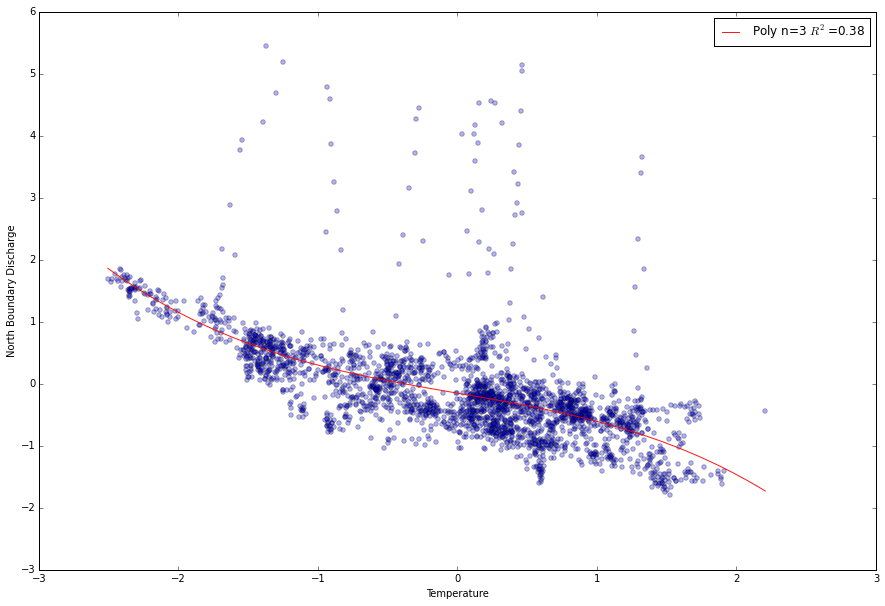

In [174]:
x0 = df1['jday']
time = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]
#BP = df1['USU_Avon_BP_ft'] 
lil_bear = df1['USU_SF_AD_std_h_ft']
#PPT_CDM = df1['PPT_CDM']
temp = df1['HL_BP_LW_std_t_C'].get_values()
#SWE = df1['WTEQ.I-1 (in) ']
Q = df1['NB_LW_std_Q_cfs']

plt.figure()
plt.scatter(temp, Q, alpha=0.3)
plt.ylabel('North Boundary Discharge')
plt.xlabel('Temperature')

est = smf.ols(formula='Q ~ time + lil_bear + temp', data=df1).fit()

xp = pd.DataFrame({'temp': np.linspace(temp.min(), temp.max(), 100)})

poly3 = smf.ols(formula='Q ~ 1 + temp + I(temp ** 2.0) + I(temp ** 3.0)', data=df1).fit()
plt.plot(xp.temp,poly3.predict(xp), 'r-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % poly3.rsquared)
plt.legend()

print est.summary()

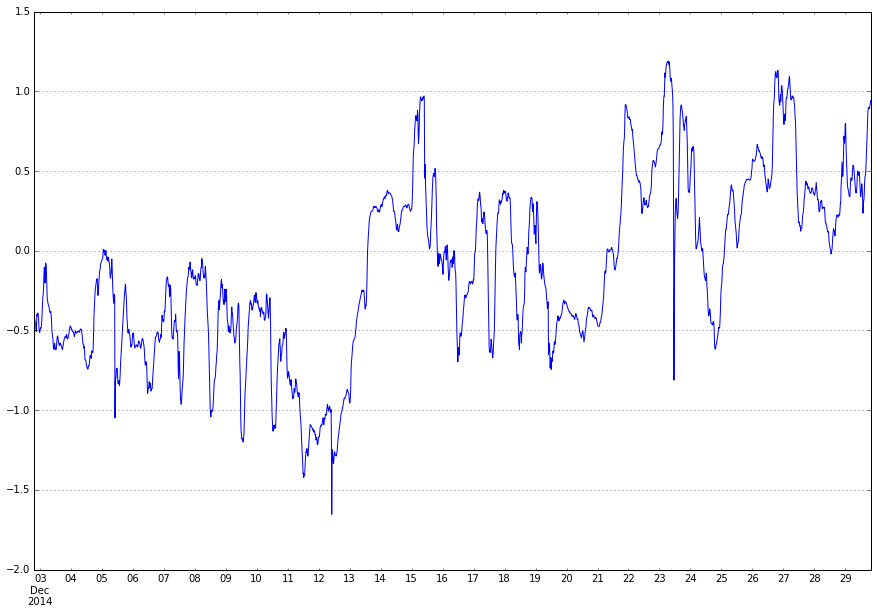

In [175]:
(df1['NB_LW_std_Q_cfs']-est.resid).plot()

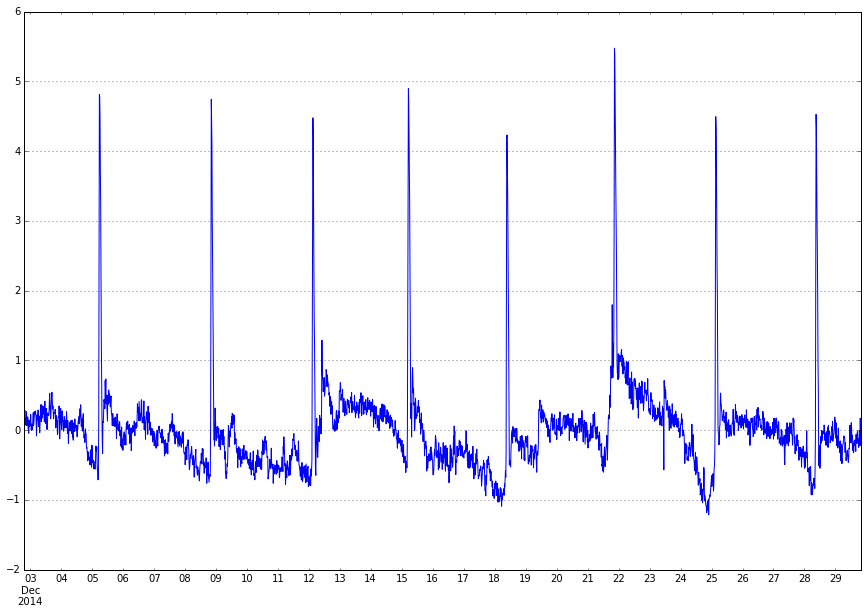

In [176]:
poly3.resid.plot()

### Hidden Lake Weir Analysis

In [177]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,25))&(All.index.to_datetime() > pd.datetime(2014,10,12))]
dflist = ['HL_JF_Q_cfs','USU_SF_BD_h_ft','USU_SF_AD_h_ft','HL_JF_t_C','EXW_wl_elev_ft','HLW_wl_elev_ft','USU_SF_PPT_in']
for i in list(df.columns.values):
    if i not in dflist:
        df = df.drop(i,axis=1)

In [178]:
df['PPT_CDM'] = (df['USU_SF_PPT_in'] - df['USU_SF_PPT_in'].mean()).cumsum()
df['jday'] = df.index.to_julian_date()

In [179]:
from pandas.tools.plotting import scatter_matrix

In [180]:
list(df.columns.values)

['USU_SF_PPT_in',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'HL_JF_t_C',
 'HL_JF_Q_cfs',
 'HLW_wl_elev_ft',
 'EXW_wl_elev_ft',
 'PPT_CDM',
 'jday']

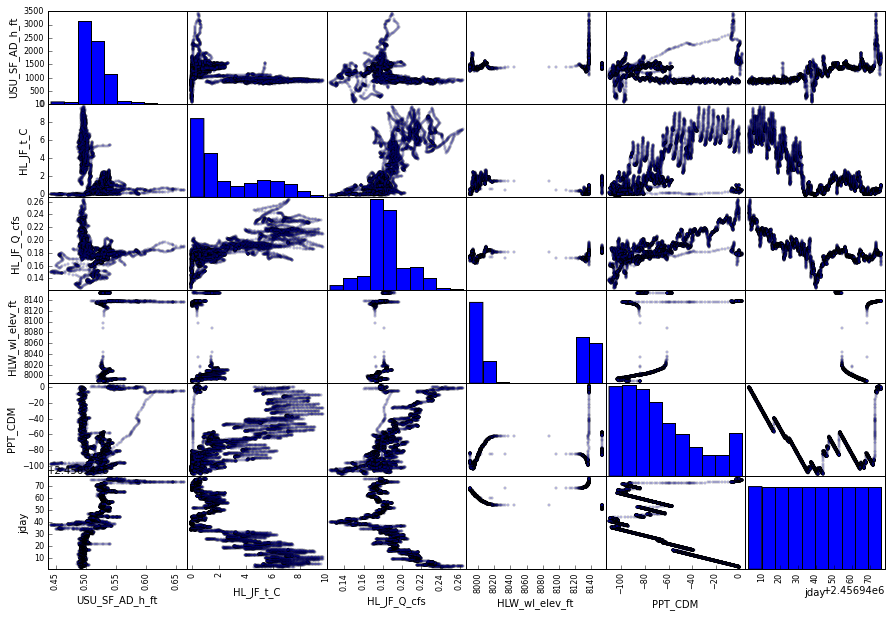

In [181]:
df1 = df.drop(['USU_SF_PPT_in','EXW_wl_elev_ft','USU_SF_BD_h_ft'],axis=1)

plt.figure()
scatter_matrix(df1, alpha=0.2, diagonal='hist')
plt.savefig('E:\\POWMOW\\Figures\\Reg_Matrix.pdf')

In [182]:
df1['dUSU_SF_AD_h_ft'] = df1['USU_SF_AD_h_ft'].diff()
df1['dHL_JF_t_C'] = df1['HL_JF_t_C'].diff()
df1['dHL_JF_Q_cfs'] = df1['HL_JF_Q_cfs'].diff()
df1['dHLW_wl_elev_ft'] = df1['HLW_wl_elev_ft'].diff()
df1['dPPT_CDM'] = df1['PPT_CDM'].diff()

df1['nUSU_SF_AD_h_ft'] = (df1['USU_SF_AD_h_ft']-df1['USU_SF_AD_h_ft'].mean())/df1['USU_SF_AD_h_ft'].std()
df1['nHL_JF_t_C'] = (df1['HL_JF_t_C']-df1['HL_JF_t_C'].mean())/df1['HL_JF_t_C'].std()
df1['nHL_JF_Q_cfs'] = (df1['HL_JF_Q_cfs']-df1['HL_JF_Q_cfs'].mean())/df1['HL_JF_Q_cfs'].std()
df1['nHLW_wl_elev_ft'] = (df1['HLW_wl_elev_ft']-df1['HLW_wl_elev_ft'].mean())/df1['HLW_wl_elev_ft'].std()
df1['nPPT_CDM'] = (df1['PPT_CDM']-df1['PPT_CDM'].mean())/df1['PPT_CDM'].std()


In [183]:
df2 = df1.drop(['nUSU_SF_AD_h_ft','nHL_JF_t_C','nHL_JF_Q_cfs','nHLW_wl_elev_ft','nPPT_CDM',
                'USU_SF_AD_h_ft','USU_SF_AD_h_ft','HL_JF_Q_cfs','HLW_wl_elev_ft','PPT_CDM','HL_JF_t_C'],axis=1)
df3 = df1.drop(['dUSU_SF_AD_h_ft','dHL_JF_t_C','dHL_JF_Q_cfs','dHLW_wl_elev_ft','dPPT_CDM',
                'USU_SF_AD_h_ft','USU_SF_AD_h_ft','HL_JF_Q_cfs','HLW_wl_elev_ft','PPT_CDM','HL_JF_t_C'],axis=1)

In [184]:
flow = df['HL_JF_Q_cfs']
time = df['jday']
lil_bear = df['USU_SF_AD_h_ft']
temp = df['HL_JF_t_C']
precip = df['USU_SF_PPT_in']
pump_well = df['HLW_wl_elev_ft']
ppt_cdm = df['PPT_CDM']


est = smf.ols(formula='flow ~ time + lil_bear + temp + ppt_cdm', data=df).fit()
print est.summary()

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     4371.
Date:                Mon, 13 Apr 2015   Prob (F-statistic):               0.00
Time:                        09:45:51   Log-Likelihood:                 21814.
No. Observations:                7103   AIC:                        -4.362e+04
Df Residuals:                    7098   BIC:                        -4.358e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    714.9523     36.477     19.600      0.0

In [185]:
df['resid']=est.resid
df['modeled']=df['HL_JF_Q_cfs']-df['resid']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x291BFE50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x295958F0>], dtype=object)

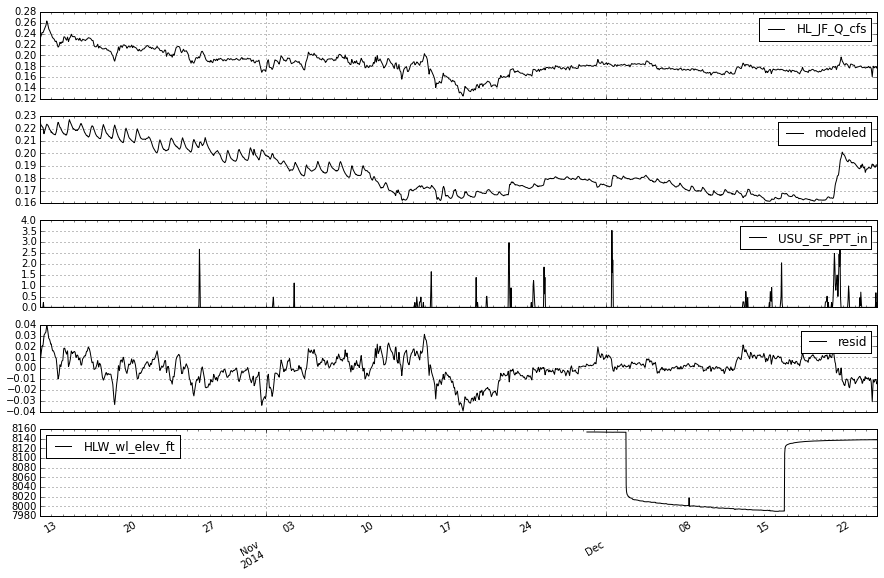

In [186]:
y0 = df['HL_JF_Q_cfs']
x0 = df['jday']
x1 = df['USU_SF_AD_h_ft']
x2 = df['HL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']


df[['HL_JF_Q_cfs','modeled','USU_SF_PPT_in','resid','HLW_wl_elev_ft']].plot(subplots=True)

In [187]:
df.to_csv('E:\\POWMOW\\hidden_lake_out.csv')

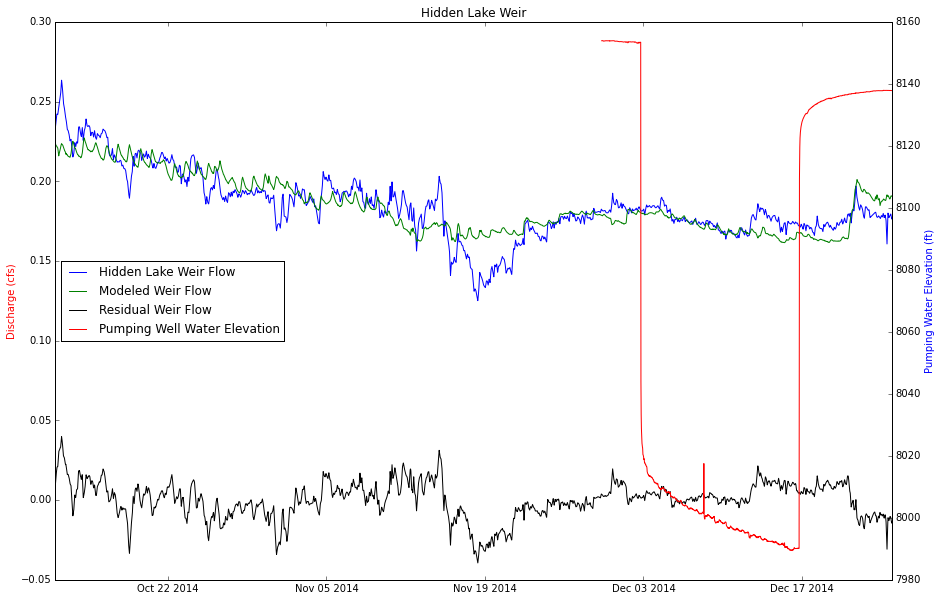

In [188]:
plt.figure()

x0 = df.index.to_datetime()
x1 = df['USU_SF_AD_h_ft']
x2 = df['HL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']
y0 = df['HL_JF_Q_cfs']

fig, ax1 = plt.subplots()
plt.title('Hidden Lake Weir')
ax2 = ax1.twinx()
ax1.plot(x0,y0,c='b',label='Hidden Lake Weir Flow')
ax1.plot(x0,x6,c='g',label='Modeled Weir Flow')
ax1.plot(x0,x7,c='black',label='Residual Weir Flow')
#ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Discharge (cfs)', color='r') 
ax2.set_ylabel('Pumping Water Elevation (ft)', color='b') 
ax2.plot(x0,x3,c='r',label='Pumping Well Water Elevation')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=6)
plt.savefig('E:\\POWMOW\\Figures\\HL_Model.pdf')
plt.show()


In [189]:
x0 = df.index.to_datetime().values
y0 = df['HL_JF_Q_cfs'].values
start_day = x0[0]
last_day = x0[-1]
date_diff = (df['jday'][-1]-df['jday'][0])
num_samps = len(x0)
interval = ((df['jday'][-1]-df['jday'][0])/len(x0))
print start_day
print last_day
print date_diff
print num_samps
print interval

2014-10-11T18:15:00.000000000-0600
2014-12-24T16:45:00.000000000-0700
73.979166667
7103
0.0104152001502


In [190]:
import rpy2
%load_ext rmagic

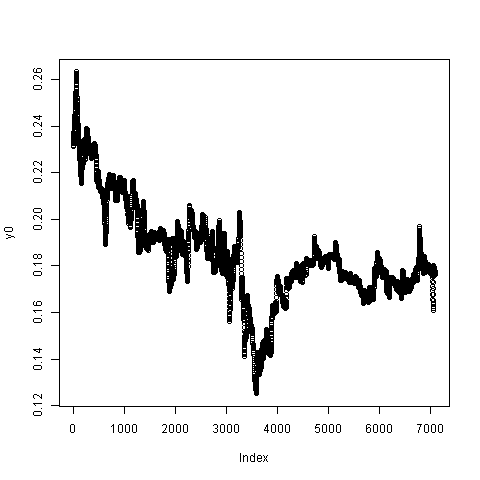

In [191]:
%R -i y0 plot(y0)

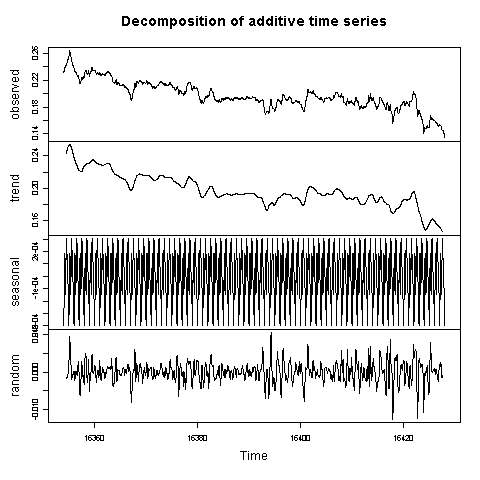

In [192]:
%%R -i y0 -o strt,lst
library(chron)

strt <-as.Date("10/11/2014 18:15:00", format='%m/%d/%Y %H:%M:%S');
lst <-as.Date("12/24/2014 16:45:00", format='%m/%d/%Y %H:%M:%S');
yser <- ts(y0, start=strt, end=lst, frequency=48)

Qtimeseriescomponents <- decompose(yser)
plot(Qtimeseriescomponents)


### Lower Lefty's Spring Analysis

[To Top](#top)

In [193]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2015,1,1))&(All.index.to_datetime() > pd.datetime(2014,11,27))]


In [194]:
dflist = ['UL_JF_t_C','WTEQ.I-1 (in) ','USU_SF_AD_h_ft','HLW_wl_elev_ft','USU_Avon_BP_mmHg',
          'HLW_wl_elev_ft','USU_SF_PPT_in','UL_JF_Q_cfs','EXW_wl_elev_ft','LL_JF_Q_cfs', 'UL_BP_LW_t_C','LL_JF_t_C','UL_BP_LW_p_ft',]
for i in list(df.columns.values):
    if i not in dflist:
        df = df.drop(i,axis=1)

In [195]:
df['UL_JF_t_C'] = df['UL_JF_t_C'].diff()
df['UL_JF_Q_cfs'] = df['UL_JF_Q_cfs'].diff()
df['PPT_CDM'] = (df['USU_SF_PPT_in'] - df['USU_SF_PPT_in'].mean()).cumsum()
df['jday'] = df.index.to_julian_date()    


                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     256.3
Date:                Mon, 13 Apr 2015   Prob (F-statistic):          1.01e-190
Time:                        09:46:06   Log-Likelihood:                 9225.7
No. Observations:                3136   AIC:                        -1.844e+04
Df Residuals:                    3131   BIC:                        -1.841e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             233.4199    

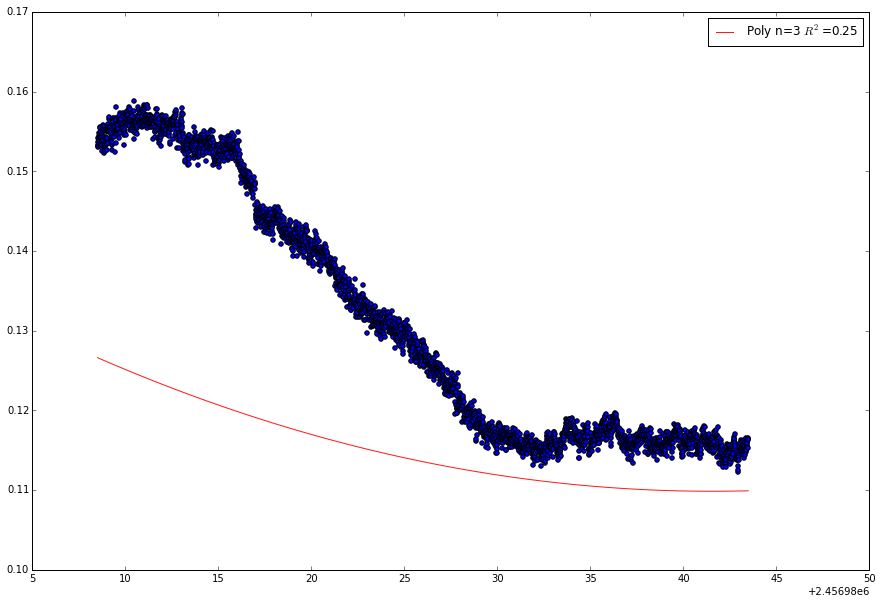

In [196]:
flow = df['LL_JF_Q_cfs']
time = df['jday']
lil_bear = df['USU_SF_AD_h_ft']
temp = df['LL_JF_t_C']
pump_well = df['HLW_wl_elev_ft']
ppt_cdm = df['PPT_CDM']
swe = df['WTEQ.I-1 (in) ']
obs_well = df['EXW_wl_elev_ft']

est = smf.ols(formula='flow ~ 1+ pump_well + lil_bear + I(pump_well**2.0) + I(lil_bear**2.0)', data=df).fit()
print est.summary()



xp = pd.DataFrame({'pump_well': np.linspace(pump_well.min(), pump_well.max(), 100), 
                  'lil_bear': np.linspace(lil_bear.min(), lil_bear.max(), 100),
                  'time':np.linspace(time.min(), time.max(), 100)})

#poly3 = smf.ols(formula='Q ~ 1 + temp + I(temp ** 2.0) + I(temp ** 3.0)', data=df1).fit()
plt.plot(xp.time,est.predict(xp), 'r-', alpha=0.9, label='Poly n=3 $R^2$=%.2f' % est.rsquared)
plt.scatter(time,flow)
plt.legend()

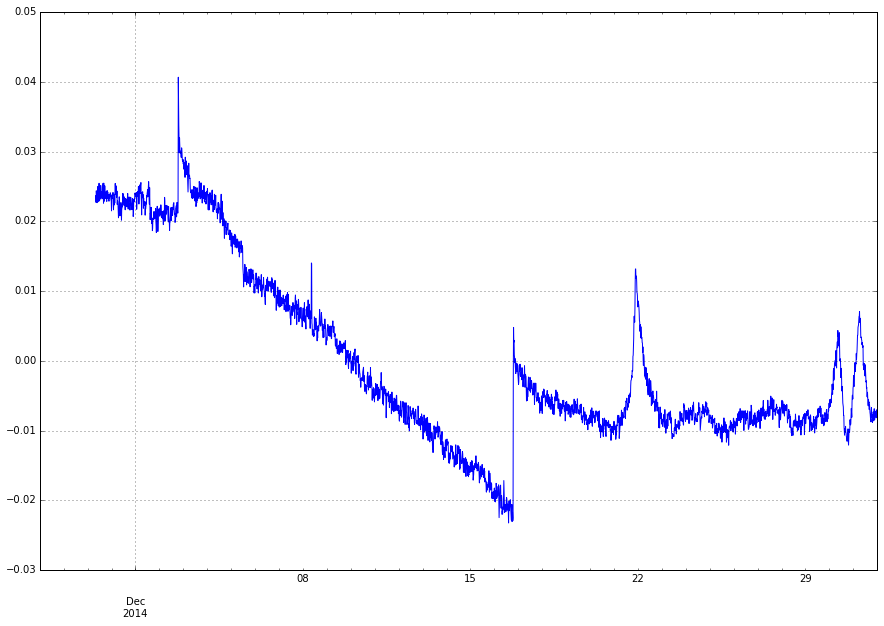

In [197]:
df['resid']=est.resid
df['modeled']=df['LL_JF_Q_cfs']-df['resid']
df['resid'].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x28CF5AD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x27F6AF30>]], dtype=object)

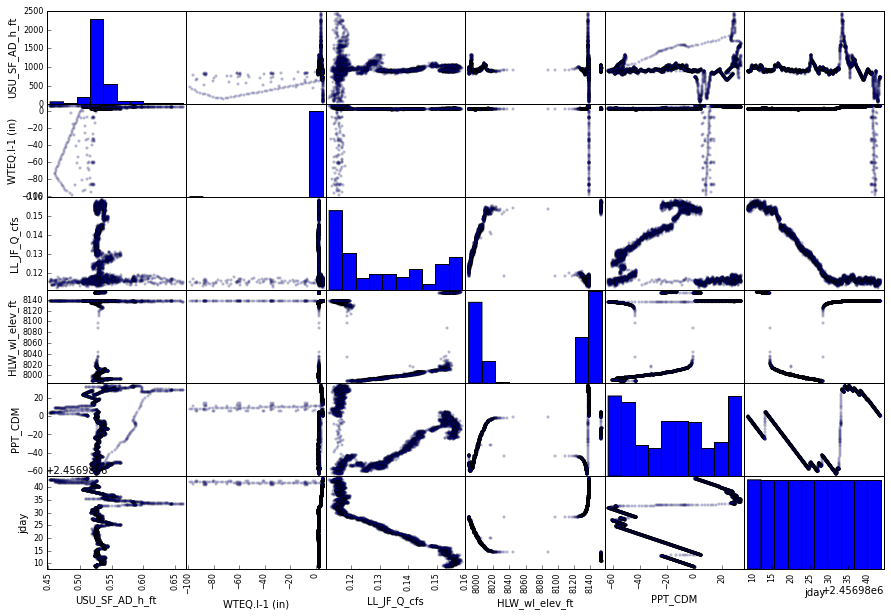

In [198]:
flow = df['LL_JF_Q_cfs']
time = df['jday']
lil_bear = df['USU_SF_AD_h_ft']
temp = df['UL_JF_t_C']
pump_well = df['HLW_wl_elev_ft']
ppt_cdm = df['PPT_CDM']
swe = df['WTEQ.I-1 (in) ']

df1 = df
dflist = ['LL_JF_Q_cfs','jday','USU_SF_AD_h_ft','HLW_wl_elev_ft','PPT_CDM','WTEQ.I-1 (in) ','HLW_wl_elev_ft']
for i in list(df.columns.values):
    if i not in dflist:
        df1 = df1.drop(i,axis=1)

scatter_matrix(df1, alpha=0.2, diagonal='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x282AD390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2ABC8990>], dtype=object)

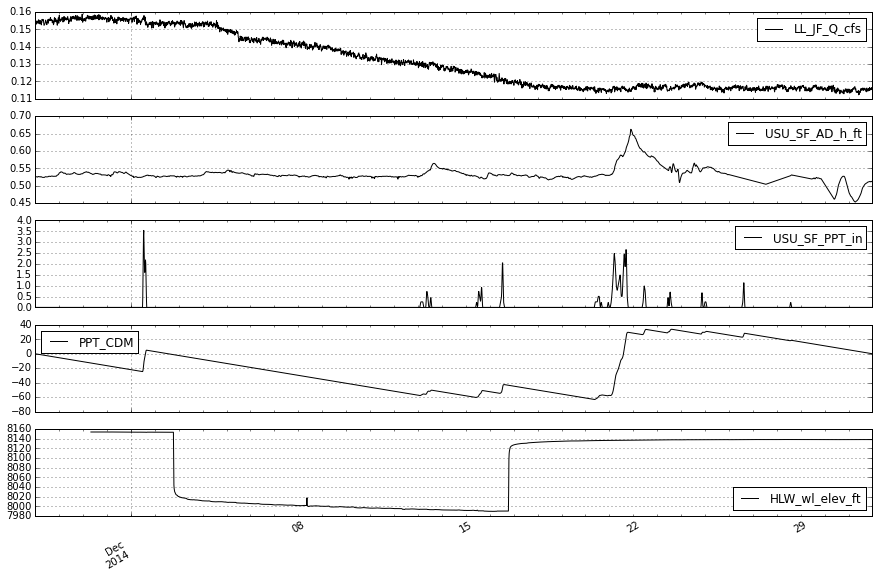

In [199]:
y0 = df['LL_JF_Q_cfs']
x0 = df['jday']
x1 = df['USU_SF_AD_h_ft']
x2 = df['UL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']


df[['LL_JF_Q_cfs','USU_SF_AD_h_ft','USU_SF_PPT_in','PPT_CDM','HLW_wl_elev_ft']].plot(subplots=True)

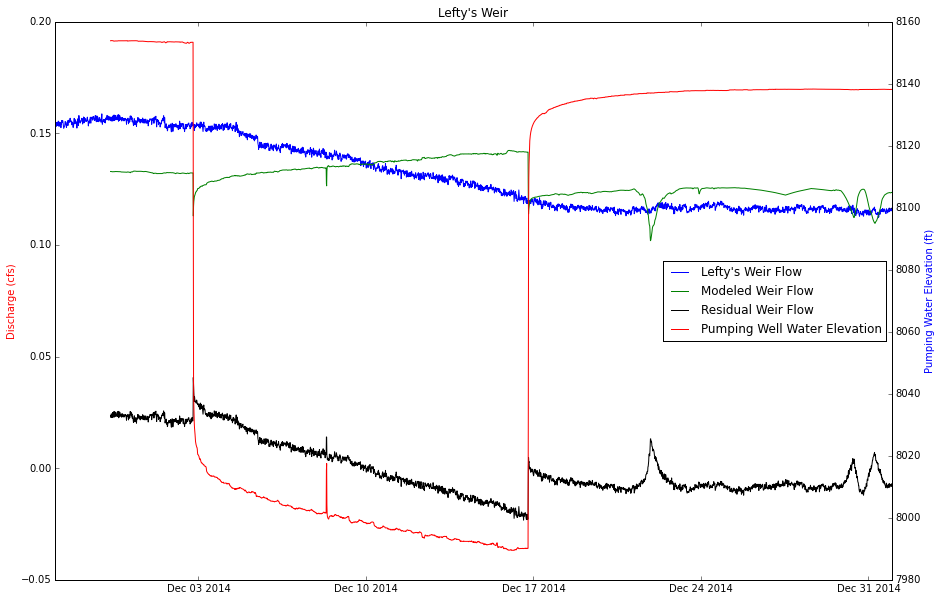

In [200]:
plt.figure()

x0 = df.index.to_datetime()
x1 = df['USU_SF_AD_h_ft']
x2 = df['LL_JF_t_C']
x3 = df['HLW_wl_elev_ft']
x4 = df['USU_SF_PPT_in']
x5 = df['PPT_CDM']
x6 = df['modeled']
x7 = df['resid']
y0 = df['LL_JF_Q_cfs']

fig, ax1 = plt.subplots()
plt.title('Lefty\'s Weir')
ax2 = ax1.twinx()
ax1.plot(x0,y0,c='b',label='Lefty\'s Weir Flow')
ax1.plot(x0,x6,c='g',label='Modeled Weir Flow')
ax1.plot(x0,x7,c='black',label='Residual Weir Flow')
#ax1.set_xlim(left='11/30/2014',right=x1[-1])
ax1.set_ylabel('Discharge (cfs)', color='r') 
ax2.set_ylabel('Pumping Water Elevation (ft)', color='b') 
ax2.plot(x0,x3,c='r',label='Pumping Well Water Elevation')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=7)

plt.show()

                    EXW_std_wl_elev_ft  LL_JF_std_Q_cfs
EXW_std_wl_elev_ft            1.000000         0.023215
LL_JF_std_Q_cfs               0.023215         1.000000
                    EXW_std_wl_elev_ft  LL_JF_std_Q_cfs
EXW_std_wl_elev_ft            1.000000         0.054239
LL_JF_std_Q_cfs               0.054239         1.000000
                    EXW_std_wl_elev_ft  LL_JF_std_Q_cfs
EXW_std_wl_elev_ft            1.000000         0.065189
LL_JF_std_Q_cfs               0.065189         1.000000


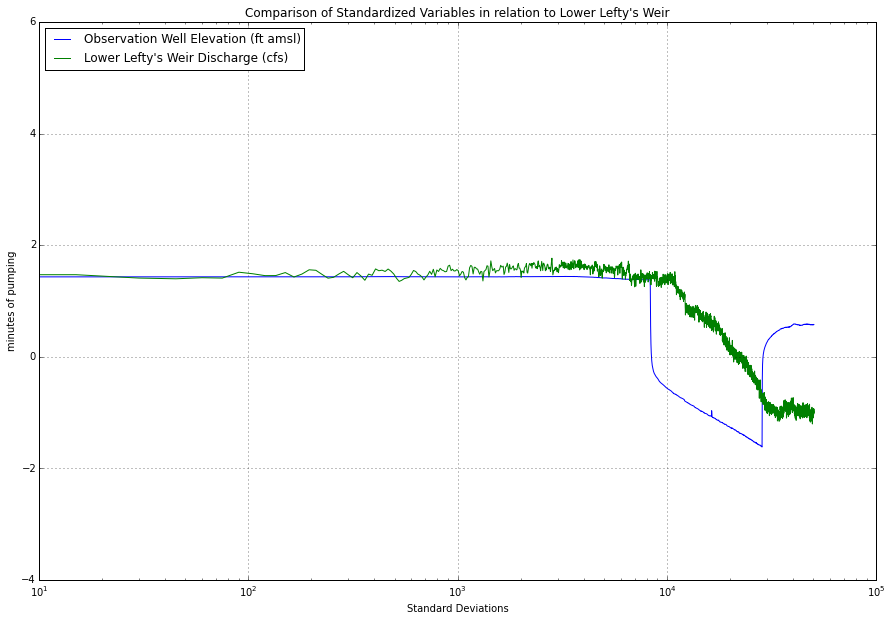

In [201]:

x0 = df['jday']
x = [(x0[i]-x0[0])*24*60 for i in range(len(x0))]

df['LL_JF_std_Q_cfs'] = (df['LL_JF_Q_cfs']-df['LL_JF_Q_cfs'].mean())/df['LL_JF_Q_cfs'].std()
df['EXW_std_wl_elev_ft'] = (df['EXW_wl_elev_ft']-df['EXW_wl_elev_ft'].mean())/df['EXW_wl_elev_ft'].std()

y5 = df['LL_JF_std_Q_cfs']
y3 = df['EXW_std_wl_elev_ft']

plt.figure()
#plt.plot(x,y1,label='USU_Avon_std_BP_ft')
#plt.plot(x,y2,label='HLW_std_Q_cfs')
plt.plot(x,y3,label='Observation Well Elevation (ft amsl)')
plt.plot(x,y5,label='Lower Lefty\'s Weir Discharge (cfs)')
plt.title('Comparison of Standardized Variables in relation to Lower Lefty\'s Weir')
plt.xlabel('Standard Deviations')
plt.ylabel('minutes of pumping')
plt.grid()
plt.ylim(-4,6)
plt.legend(loc=2)
plt.xscale('log')
plt.savefig('E:\\POWMOW\\Figures\\Semilog_Leftys_and_Obs_Well.pdf')


print df[['EXW_std_wl_elev_ft','LL_JF_std_Q_cfs']].corr(method='spearman')
print df[['EXW_std_wl_elev_ft','LL_JF_std_Q_cfs']].corr(method='kendall')
print df[['EXW_std_wl_elev_ft','LL_JF_std_Q_cfs']].corr(method='pearson')


### Upper Lefty's Spring Analysis

In [202]:
list(All.columns.values)

['USU_Avon_BP_mmHg',
 'USU_SF_BP_mmHg',
 'USU_SF_PPT_in',
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'USU_SF_BD_h_ft',
 'Site Id',
 'WTEQ.I-1 (in) ',
 'PREC.I-1 (in) ',
 'TOBS.I-1 (degC) ',
 'SNWD.I-1 (in) ',
 'SMS.I-1:-2 (pct)  (silt)',
 'SMS.I-1:-8 (pct)  (silt)',
 'SMS.I-1:-20 (pct)  (silt)',
 'STO.I-1:-2 (degC) ',
 'STO.I-1:-8 (degC) ',
 'STO.I-1:-20 (degC) ',
 'SAL.I-1:-2 (gram) ',
 'SAL.I-1:-8 (gram) ',
 'SAL.I-1:-20 (gram) ',
 'RDC.I-1:-2 (unit) ',
 'RDC.I-1:-8 (unit) ',
 'RDC.I-1:-20 (unit) ',
 'BATT.I-1 (volt) ',
 'UL_LW_t_C',
 'UL_JF_t_C',
 'UL_BP_LW_p_cm',
 'UL_BP_LW_t_C',
 'UL_BP_LW_p_ft',
 'UL_LW_Q_gpm',
 'UL_LW_Q_cfs',
 'UL_JF_Q_gpm',
 'UL_JF_Q_cfs',
 'LL_LW_t_C',
 'LL_JF_t_C',
 'LL_LW_Q_gpm',
 'LL_JF_Q_gpm',
 'LL_JF_Q_cfs',
 'LL_LW_Q_cfs',
 'HL_LW_t_C',
 'HL_BP_LW_p_cm',
 'HL_BP_LW_t_C',
 'HL_BP_LW_p_ft',
 'HL_JF_t_C',
 'HL_LW_Q_gpm',
 'HL_JF_Q_gpm',
 'HL_JF_Q_cfs',
 'HL_LW_Q_cfs',
 'NB_LW_t_C',
 'NB_US_t_C',
 'NB_US_Q_gpm',
 'NB_LW_Q_gpm',
 'NB_US_Q_cfs',
 'NB_LW_Q_cfs',
 'HLW

In [203]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2015,1,1))&(All.index.to_datetime() > pd.datetime(2014,11,27,12))]

In [204]:
well = df['HLW_wl_elev_ft'].diff().values
obswell = df['EXW_wl_elev_ft'].diff().values
pump = df['HLW_Q_gpm'].diff().values
llstream = df['LL_JF_Q_cfs'].diff().values
ulstream = df['UL_JF_Q_cfs'].diff().values

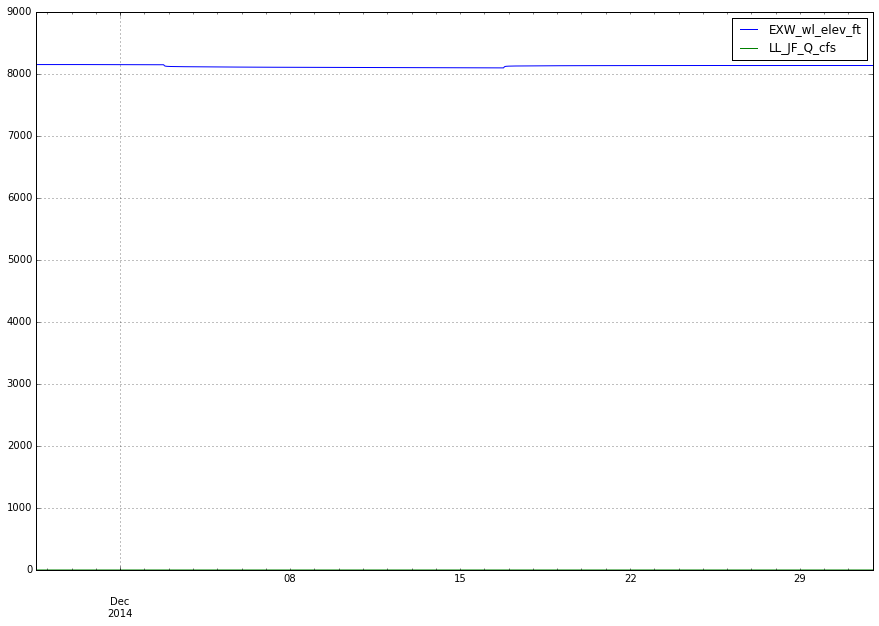

In [205]:
df[['EXW_wl_elev_ft','LL_JF_Q_cfs']].plot()

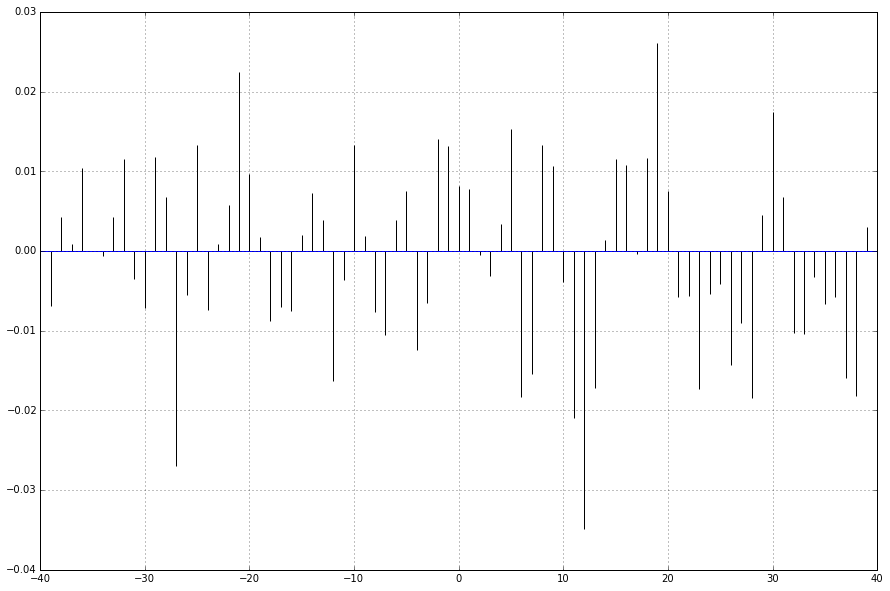

In [206]:
plt.xcorr(obswell[1:],llstream[1:],maxlags=40)
plt.grid()

In [207]:
from IPython.display import display

In [208]:
%load_ext rpy2.ipython 
%R require(ggplot2)

<Vector - Python:0x2CE59E40 / R:0x2B780B70>
[       1]

<a href=http://www.r-bloggers.com/chicken-or-the-egg-granger-causality-for-the-masses/>From r-bloggers</a>

In [209]:
%R -i well,llstream library(MSBVAR); df <- data.frame(well,llstream); print(granger.test(df, 1))

<Matrix - Python:0x2CEE1620 / R:0x2DDDD600>
[0.220311, 245.696372, 0.638834, 0.000000]

In [210]:
%R -i well,pump library(MSBVAR); df <- data.frame(well,pump); print(granger.test(df, 1))

<Matrix - Python:0x2D102D50 / R:0x2DDA85D0>
[210.322206, 591.161743, 0.000000, 0.000000]

In [211]:
%R -i obswell,pump library(MSBVAR); df <- data.frame(obswell,pump); print(granger.test(df, 1))

<Matrix - Python:0x2D102AD0 / R:0x1E6F9CE0>
[1190.608844, 157.858819, 0.000000, 0.000000]

In [212]:
%R -i well,ulstream library(MSBVAR); df <- data.frame(well,ulstream); print(granger.test(df, 1))

<Matrix - Python:0x2D102D00 / R:0x1E7149D8>
[2557.228278, 354.810837, 0.000000, 0.000000]

In [213]:
print ulstream

[        nan  0.00087324 -0.00116883 ...,         nan         nan
         nan]


In [214]:
print obswell


[       nan -0.0124578 -0.0012304 ...,  0.0036912  0.0118426  0.0126116]


In [215]:
well


array([        nan,         nan,         nan, ...,  0.00288851,
        0.00144426, -0.00144426])

In [216]:
%R -i obswell,llstream library(lmtest); print(grangertest(llstream~obswell,order=12,na.action = na.omit))

<DataFrame - Python:0x2CBA4670 / R:0x2DCE4460>
[FloatVector, FloatVector, FloatVector, FloatVector]
  Res.Df: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x2D10FF58 / R:0x2DCE4028>
[3273.000000, 3285.000000]
  Df: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x2D10F350 / R:0x2DCE4118>
[NA_real_, -12.000000]
  F: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x2D10FAF8 / R:0x2DCE41B8>
[NA_real_, 0.906922]
  Pr(>F): <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x2D10FF30 / R:0x2DCE42A8>
[NA_real_, 0.539092]

In [217]:
for i in list(All.columns.values):
    print i
    print All[i].count()

USU_Avon_BP_mmHg
35469
USU_SF_BP_mmHg
35473
USU_SF_PPT_in
35473
USU_PPT_CDM
35473
USU_SF_AD_h_ft
35473
USU_SF_BD_h_ft
35427
Site Id
36893
WTEQ.I-1 (in) 
36893
PREC.I-1 (in) 
36893
TOBS.I-1 (degC) 
36893
SNWD.I-1 (in) 
36893
SMS.I-1:-2 (pct)  (silt)
36893
SMS.I-1:-8 (pct)  (silt)
36893
SMS.I-1:-20 (pct)  (silt)
36893
STO.I-1:-2 (degC) 
36893
STO.I-1:-8 (degC) 
36893
STO.I-1:-20 (degC) 
36893
SAL.I-1:-2 (gram) 
36893
SAL.I-1:-8 (gram) 
36893
SAL.I-1:-20 (gram) 
36893
RDC.I-1:-2 (unit) 
36893
RDC.I-1:-8 (unit) 
36893
RDC.I-1:-20 (unit) 
36893
BATT.I-1 (volt) 
36893
UL_LW_t_C
13846
UL_JF_t_C
3084
UL_BP_LW_p_cm
13847
UL_BP_LW_t_C
13847
UL_BP_LW_p_ft
13847
UL_LW_Q_gpm
13846
UL_LW_Q_cfs
13846
UL_JF_Q_gpm
3084
UL_JF_Q_cfs
3084
LL_LW_t_C
2763
LL_JF_t_C
3434
LL_LW_Q_gpm
2763
LL_JF_Q_gpm
3434
LL_JF_Q_cfs
3434
LL_LW_Q_cfs
2763
HL_LW_t_C
5642
HL_BP_LW_p_cm
5647
HL_BP_LW_t_C
5647
HL_BP_LW_p_ft
5647
HL_JF_t_C
12797
HL_LW_Q_gpm
5642
HL_JF_Q_gpm
12797
HL_JF_Q_cfs
12797
HL_LW_Q_cfs
5642
NB_LW_t_C
5645
N

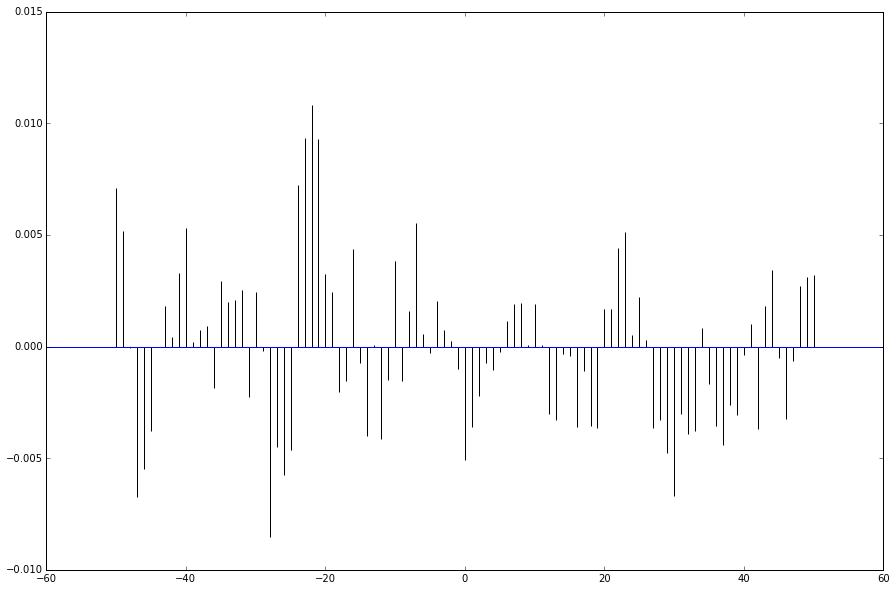

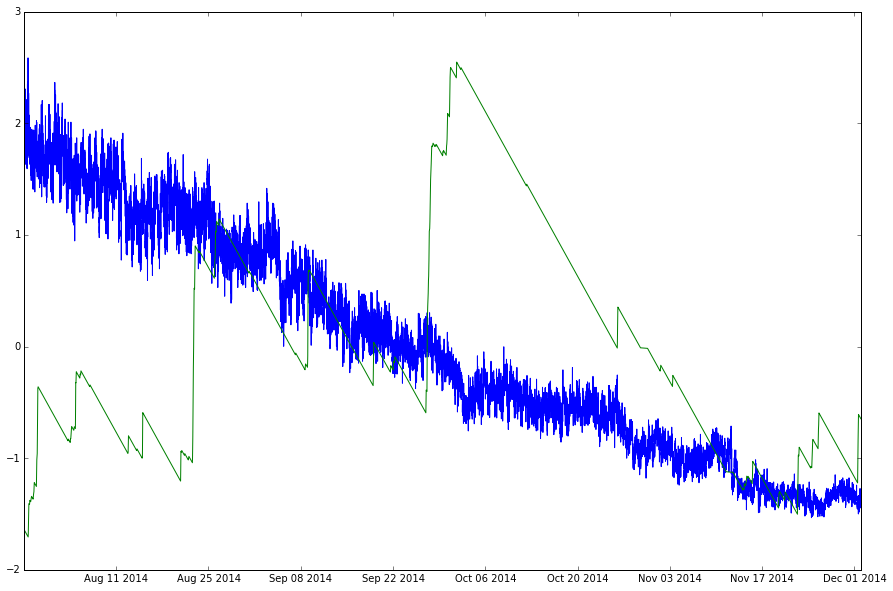

In [218]:
try:
    del dfa
except (NameError):
    pass
dfa = All[(All.index.to_datetime() < pd.datetime(2014,12,2))&(All.index.to_datetime() > pd.datetime(2014,7,28))]

ulspring = dfa['UL_LW_Q_cfs'].diff().values[100:-100]
ppt = dfa['USU_PPT_CDM'].diff().values[100:-100]
time = dfa.index.to_datetime()
spngstd = (dfa['UL_LW_Q_cfs']-dfa['UL_LW_Q_cfs'].mean())/dfa['UL_LW_Q_cfs'].std()
pptstd = (dfa['USU_PPT_CDM']-dfa['USU_PPT_CDM'].mean())/dfa['USU_PPT_CDM'].std()
plt.xcorr(ulspring,ppt,maxlags=50)
plt.figure()
plt.plot(time,spngstd)
plt.plot(time, pptstd)

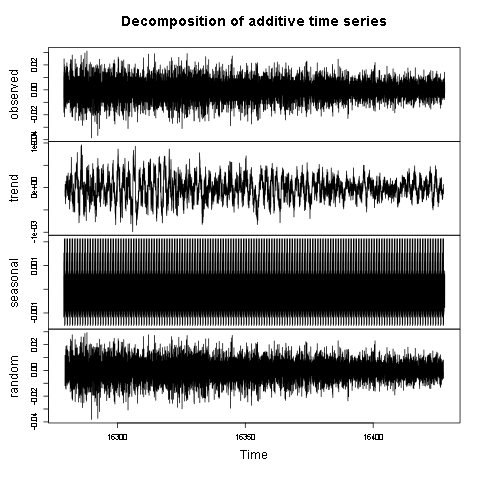

In [219]:
%%R -i ulspring -o QTS
library(chron)
library(MASS)
y0<-ulspring
strt <-as.Date("07/28/2014 08:00:00", format='%m/%d/%Y %H:%M:%S');
lst <-as.Date("12/24/2014 16:45:00", format='%m/%d/%Y %H:%M:%S');
yser <- ts(y0, start=strt, end=lst, frequency=48)

QTS<- decompose(yser)
plot(QTS)
#y1<-boxcox(y0)
#qqnorm(y1)
#abline(0,1)


In [220]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,30))&(All.index.to_datetime() > pd.datetime(2014,11,4,15,15))]

In [221]:
print df['NB_LW_Q_cfs']

2014-11-04 15:30:00    1.102509
2014-11-04 15:45:00    1.102509
2014-11-04 16:00:00    1.102509
2014-11-04 16:15:00    1.107309
2014-11-04 16:30:00    1.118765
2014-11-04 16:45:00    1.110169
2014-11-04 17:00:00    1.115897
2014-11-04 17:15:00    1.112001
2014-11-04 17:30:00    1.085424
2014-11-04 17:45:00    1.062782
2014-11-04 18:00:00    1.053433
2014-11-04 18:15:00    1.066507
2014-11-04 18:30:00    1.081677
2014-11-04 18:45:00    1.082585
2014-11-04 19:00:00    1.040300
...
2014-12-29 20:15:00    1.423802
2014-12-29 20:30:00    1.433139
2014-12-29 20:45:00    1.393813
2014-12-29 21:00:00    1.455005
2014-12-29 21:15:00    1.442497
2014-12-29 21:30:00    1.427908
2014-12-29 21:45:00    1.511735
2014-12-29 22:00:00    1.484288
2014-12-29 22:15:00    1.476981
2014-12-29 22:30:00    1.437254
2014-12-29 22:45:00    1.481137
2014-12-29 23:00:00    1.503243
2014-12-29 23:15:00    1.495904
2014-12-29 23:30:00    1.514908
2014-12-29 23:45:00    1.518083
Name: NB_LW_Q_cfs, Length: 5314


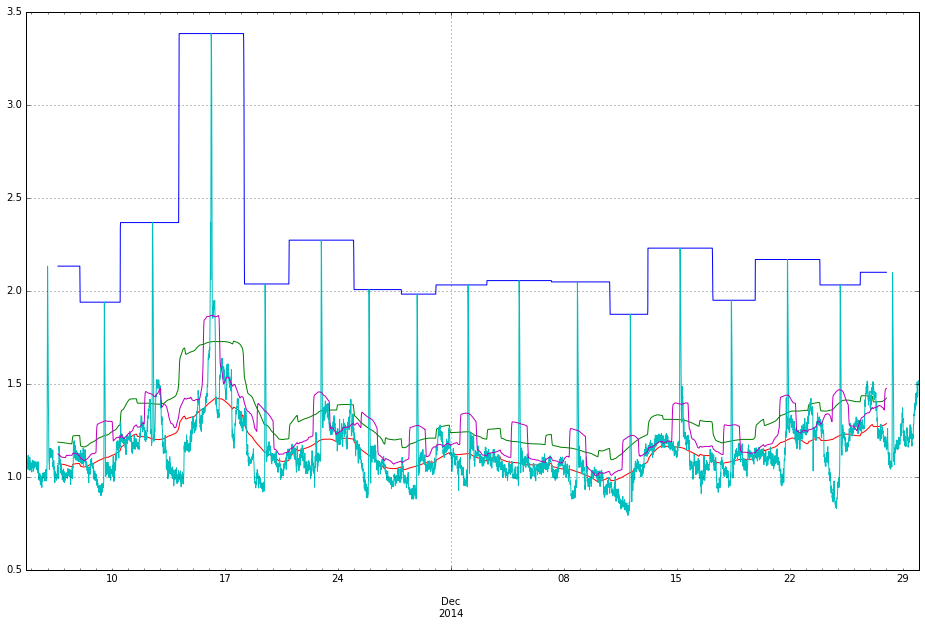

In [222]:
plt.figure(figsize=(16, 10))

df['NBMax'] = pd.rolling_max(df['NB_LW_Q_cfs'],4*24*4,center=True)
dg = df[df['NB_LW_Q_cfs']==df['NBMax']]
df['NBStd'] = pd.rolling_std(df['NB_LW_Q_cfs'],4*24*4,center=True)+ pd.rolling_mean(df['NB_LW_Q_cfs'],4*24*4,center=True)
df['TrdNBStd'] = pd.rolling_std(df['NB_LW_Q_cfs'],4*24,center=True)+ pd.rolling_mean(df['NB_LW_Q_cfs'],4*24*4,center=True)
df['NBMean'] = pd.rolling_mean(df['NB_LW_Q_cfs'],4*24*4,center=True)
df['NBMax'].plot()
df['NBStd'].plot()
df['NBMean'].plot()
df['NB_LW_Q_cfs'].plot()
df['TrdNBStd'].plot()

#dg.to_csv("E:\\POWMOW\\burp_time.csv")

-c:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


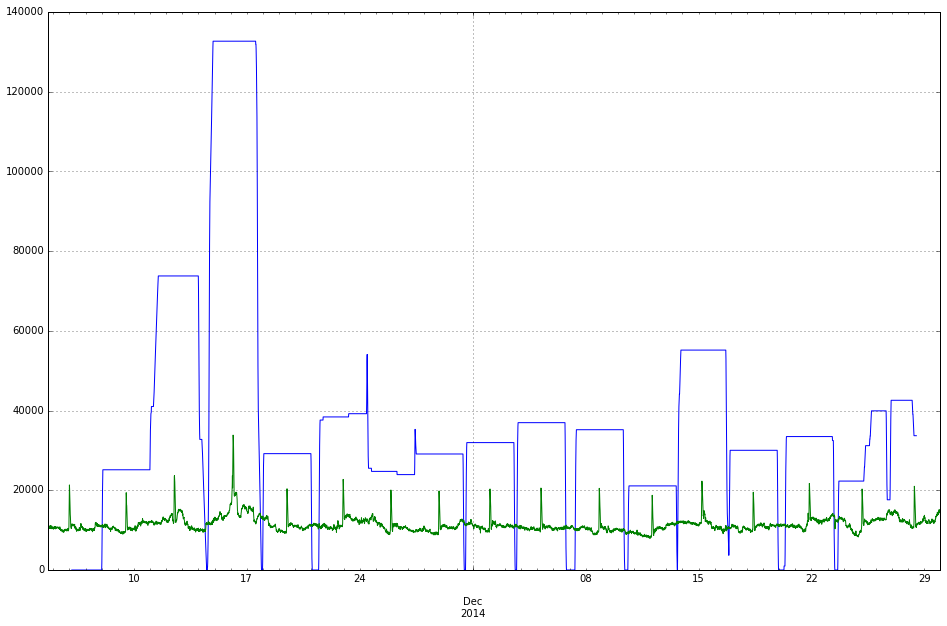

In [223]:
plt.figure(figsize=(16, 10))

df['SmoothNB'] = df['NB_LW_Q_cfs'][df['NB_LW_Q_cfs']<df['NBStd']]

df['SmoothNB'] = df['SmoothNB'].interpolate(method='time') 
df['SmoothNBMean'] = pd.rolling_mean(df['SmoothNB'],window=4*24*3,center=True)
df['SmoothNBStd'] = pd.rolling_std(df['SmoothNB'],window=4*24*3,center=True)+df['SmoothNBMean']

df['time'] = df.index.to_julian_date()
df['time_change'] = df['time'].diff()
df['Vol_Out']= (df['NB_LW_Q_cfs']-df['SmoothNBStd'])*646316.883*df['time_change']
df['Vol_Out'] = df['Vol_Out'][df['Vol_Out']>750]
df['Tot_Vol'] = pd.rolling_sum(df['Vol_Out'].fillna(0),window=4*24*3,center=True)
#df['SmoothNB'].plot()
df['Tot_Vol'].plot()
(df['NB_LW_Q_cfs']*10000).plot()
dg = df[df['NB_LW_Q_cfs']==df['NBMax']]
dg.to_csv("E:\\POWMOW\\Volumes1.csv")
#df.to_csv("E:\\POWMOW\\Volumes2.csv")

## VAR Model

In [224]:
from statsmodels.graphics.api import qqplot

In [315]:
try:
    del df
except (NameError):
    pass
df = All[(All.index.to_datetime() < pd.datetime(2014,12,29))&(All.index.to_datetime() > pd.datetime(2014,10,5))]

In [316]:
dflist = [
 'USU_PPT_CDM',
 'USU_SF_AD_h_ft',
 'WTEQ.I-1 (in) ',
 'UL_BP_LW_t_C',
 'UL_BP_LW_p_ft',
 'UL_LW_Q_cfs']
for i in list(df.columns.values):
    if i not in dflist:
        df = df.drop(i,axis=1)
df.head(n=5)

USU_PPT_CDM  USU_SF_AD_h_ft  WTEQ.I-1 (in)   \
2014-10-05 00:15:00    39.063925        0.478601        0.146667   
2014-10-05 00:30:00    39.050415        0.478588        0.246667   
2014-10-05 00:45:00    39.036906        0.477498        0.346667   
2014-10-05 01:00:00    39.023397        0.476721        0.400000   
2014-10-05 01:15:00    39.009887        0.476302        0.400000   

                     UL_BP_LW_t_C  UL_BP_LW_p_ft  UL_LW_Q_cfs  
2014-10-05 00:15:00         2.843      25.450296     0.081216  
2014-10-05 00:30:00         2.857      25.450296     0.081216  
2014-10-05 00:45:00         2.967      25.444555     0.090712  
2014-10-05 01:00:00         3.063      25.444555     0.079677  
2014-10-05 01:15:00         3.023      25.444555     0.084293

In [317]:
mdata = df#.drop(['UL_BP_LW_p_ft','USU_SF_PPT_in','UL_JF_t_C','USU_Avon_BP_mmHg','UL_JF_Q_cfs','HLW_wl_elev_ft','UL_BP_LW_t_C'],axis=1)
names = mdata.columns.values.tolist()
data = mdata.dropna()
model = sm.tsa.VAR(data)
res = model.fit(2)

In [318]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Apr, 2015
Time:                     14:25:19
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -53.8868
Nobs:                     6981.00    HQIC:                  -53.9369
Log likelihood:           129003.    FPE:                3.66460e-24
AIC:                     -53.9633    Det(Omega_mle):     3.62392e-24
--------------------------------------------------------------------
Results for equation USU_PPT_CDM
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.038867         0.052412            0.742           0.458
L1.USU_PPT_CDM            1.921227         0.004650          413.179           0.000
L1.USU_SF_AD_h_ft         0.295150    

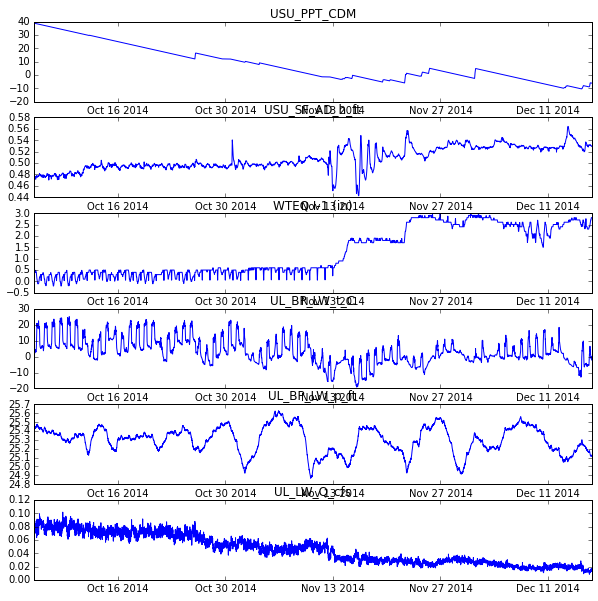

In [319]:
res.plot()

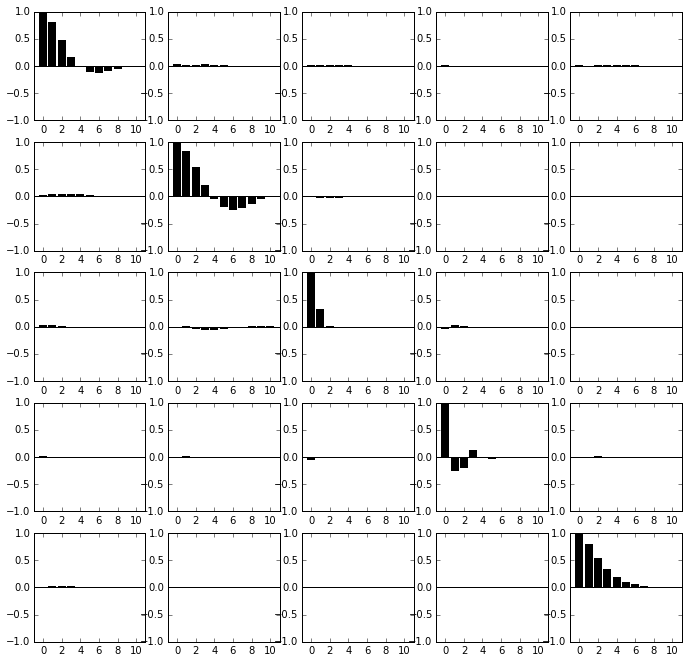

In [266]:
res.plot_acorr()

In [267]:
model.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -64.10       -64.09    1.450e-28       -64.10
1        -67.58       -67.52    4.473e-30       -67.56
2        -68.50       -68.39    1.784e-30       -68.46
3        -68.68       -68.52    1.488e-30       -68.62
4        -68.77       -68.57    1.356e-30       -68.70
5        -69.01       -68.75    1.075e-30       -68.91
6        -69.22       -68.91    8.672e-31       -69.11
7        -69.26       -68.91    8.304e-31       -69.14
8        -69.29       -68.88    8.120e-31       -69.14
9        -69.35       -68.90    7.602e-31       -69.19
10       -69.42      -68.92*    7.111e-31       -69.24
11       -69.45       -68.90    6.861e-31       -69.26
12       -69.46       -68.86    6.813e-31       -69.25
13       -69.51       -68.86    6.473e-31       -69.28
14       -69.55       -68.85    6.266e-31       -69.29
15      -6

{'aic': 15, 'bic': 10, 'fpe': 15, 'hqic': 15}

In [268]:
results = model.fit(maxlags=15, ic='bic')

In [269]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Apr, 2015
Time:                     11:45:15
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -68.8241
Nobs:                     3055.00    HQIC:                  -69.3041
Log likelihood:           84979.1    FPE:                6.09071e-31
AIC:                     -69.5734    Det(Omega_mle):     5.38652e-31
--------------------------------------------------------------------
Results for equation USU_SF_AD_h_ft
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000002         0.000011           -0.144           0.886
L1.USU_SF_AD_h_ft          1.744257         0.018126           96.230           0.000
L1.WTEQ.I-1 (in)           0.00

In [287]:
irf = res.irf(15)

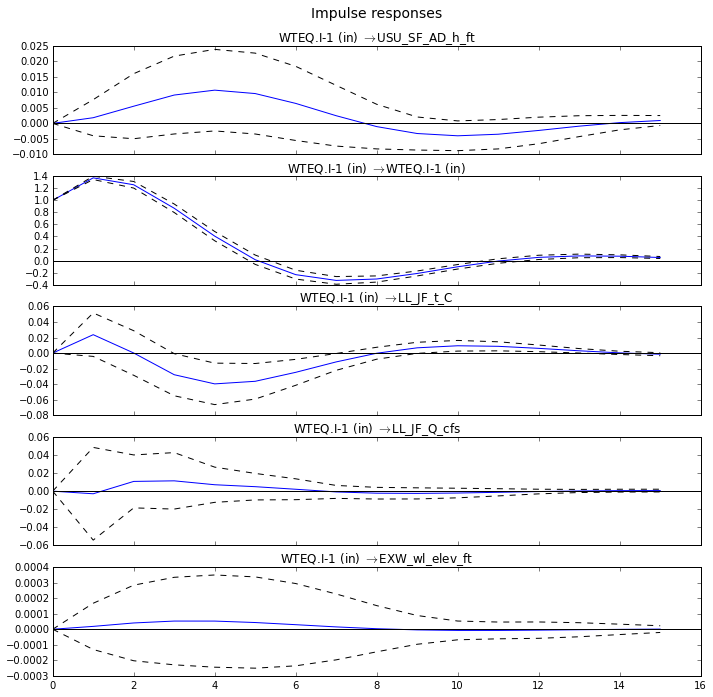

In [288]:
irf.plot(orth=False, impulse='WTEQ.I-1 (in) ')

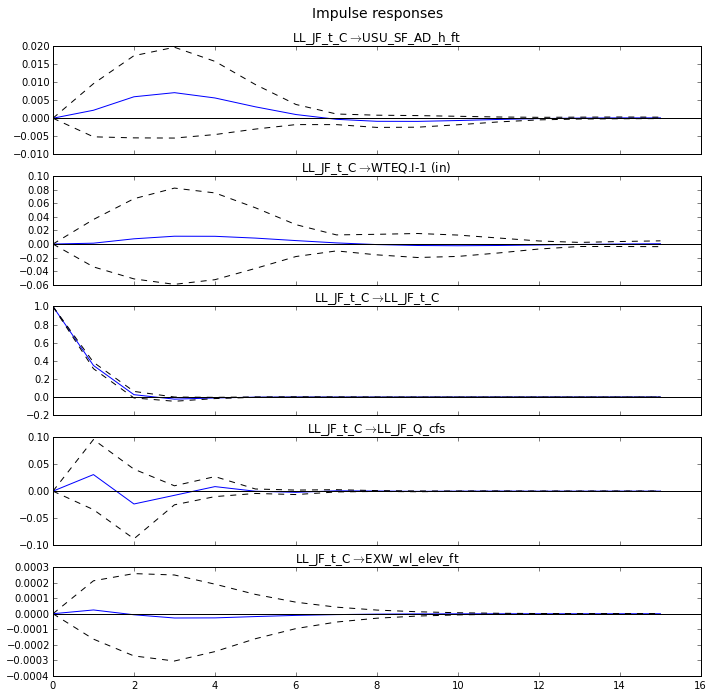

In [289]:
irf.plot(orth=False, impulse='LL_JF_t_C')

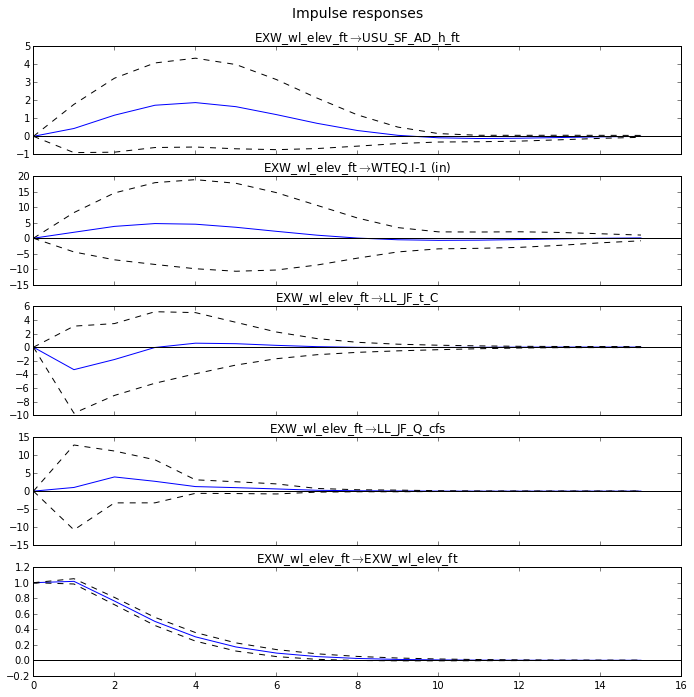

In [290]:
irf.plot(orth=False, impulse='EXW_wl_elev_ft')

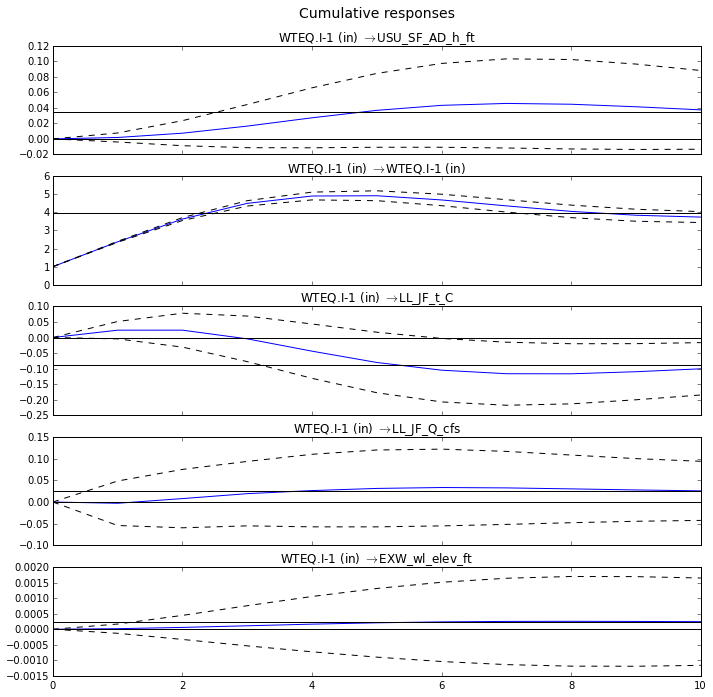

In [277]:
irf.plot_cum_effects(orth=False, impulse='WTEQ.I-1 (in) ')

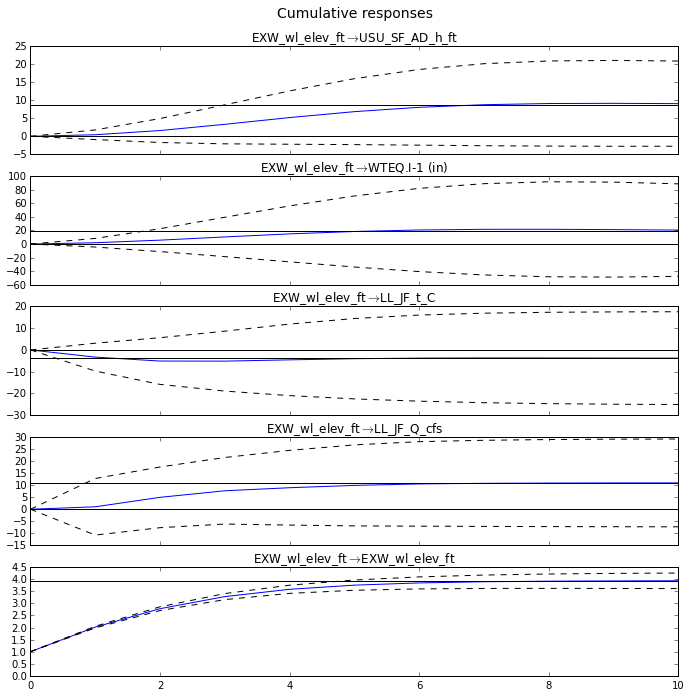

In [278]:
irf.plot_cum_effects(orth=False, impulse='EXW_wl_elev_ft')

In [280]:
res.test_causality('LL_JF_Q_cfs', ['EXW_wl_elev_ft'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value          df
---------------------------------------------------------------
         0.653870         2.996319            0.520  (2, 15285)
H_0: ['EXW_wl_elev_ft'] do not Granger-cause LL_JF_Q_cfs
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.9963194887755265,
 'df': (2, 15285),
 'pvalue': 0.52004411217712088,
 'signif': 0.05,
 'statistic': 0.65386960986566123}

## DynamicVAR

In [282]:
var = sm.tsa.DynamicVAR(data, lag_order=2, window_type='expanding')

In [285]:
var.coefs.major_xs(datetime(2014, 11, 30)).T

EXW_wl_elev_ft  LL_JF_Q_cfs  LL_JF_t_C  USU_SF_AD_h_ft  \
L1.USU_SF_AD_h_ft    1.846170e-04    -0.614105   0.132240        1.063480   
L1.WTEQ.I-1 (in)    -4.069180e-05    -0.098249  -0.009350        0.000933   
L1.LL_JF_t_C         1.097303e-06    -0.078935   0.437198        0.003053   
L1.LL_JF_Q_cfs      -2.671328e-05    -0.352905   0.007052       -0.004365   
L1.EXW_wl_elev_ft   -5.240591e-01   129.412962  -5.326391      -30.092397   
L2.USU_SF_AD_h_ft   -2.939440e-04     0.865279  -0.130775       -0.437583   
L2.WTEQ.I-1 (in)     3.697875e-05    -0.009966   0.002774       -0.000331   
L2.LL_JF_t_C        -3.907848e-06     0.019922  -0.005059        0.010082   
L2.LL_JF_Q_cfs       2.435677e-06    -0.348297   0.010557       -0.005472   
L2.EXW_wl_elev_ft   -1.945697e-01   185.156282 -57.170253      -52.194512   
intercept           -2.473052e-08     0.000020  -0.000003        0.000009   

                   WTEQ.I-1 (in)   
L1.USU_SF_AD_h_ft       -0.466285  
L1.WTEQ.I-1 (in)         1.296907  
L1.LL_JF_t_C             0.078076  
L1.LL_JF_Q_cfs           0.066787  
L1.EXW_wl_elev_ft      141.936317  
L2.USU_SF_AD_h_ft       -0.273061  
L2.WTEQ.I-1 (in)        -0.674193  
L2.LL_JF_t_C            -0.216268  
L2.LL_JF_Q_cfs           0.069847  
L2.EXW_wl_elev_ft      -42.306048  
intercept               -0.000083